# Analysis of Football Data

I will be looking into, firstly, the Premier League specifically betting odds and their accuracy in predicting game outcomes and then looking into the goal data. Later I explore the provided Fifa team attributes and the correletion within them and to their teams performance.

In terms of research questions the three avenues are:
1. How well do betting odds predict the outcomes of matches?
2. Who are the most effective penalty takers?
3. How do team attributes relate to real performance and to other attributes?

The data used is available here [European Soccer Database](https://www.kaggle.com/hugomathien/soccer).

Firstly we import required packages.

In [1]:
import sqlite3 as sq
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
% matplotlib inline
% config InlineBackend.figure_format = 'retina'

## Premier League Betting Odds

We read in the pertinent columns from the database (excluding mainly the player and player positions columns) where the league matches the Premier League id of 1729, and make the m (match) dataframe.

In [2]:
con = sq.connect('./database.sqlite')
m = pd.read_sql_query("SELECT season, date, match_api_id, home_team_api_id, away_team_api_id, \
                    home_team_goal, away_team_goal, goal,\
                    B365H, B365D, B365A, BWH, BWD, BWA, IWH, IWD, IWA, LBH, LBD, LBA, PSH, PSD, PSA\
                    WHH, WHD, WHA, SJH, SJD, SJA, VCH, VCD, VCA, GBH, GBD, GBA, BSH, BSD, BSA \
                    FROM Match \
                    WHERE league_id = '1729'",con)
m.head()

,season,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,goal,B365H,B365D,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,2008/2009,2008-08-17 00:00:00,489042,10260,10261,1,1,<goal><value><comment>n</comment><stats><goals...,1.29,5.5,...,10.00,1.28,5.5,12.00,1.30,4.75,10.0,1.29,4.50,11.00
1,2008/2009,2008-08-16 00:00:00,489043,9825,8659,1,0,<goal><value><comment>n</comment><stats><goals...,1.20,6.5,...,12.00,1.25,6.0,13.00,1.22,5.50,13.0,1.22,5.00,13.00
2,2008/2009,2008-08-16 00:00:00,489044,8472,8650,0,1,<goal><value><comment>n</comment><stats><goals...,5.50,3.6,...,1.73,5.50,3.8,1.65,5.00,3.40,1.7,4.50,3.40,1.73
3,2008/2009,2008-08-16 00:00:00,489045,8654,8528,2,1,<goal><value><comment>n</comment><stats><goals...,1.91,3.4,...,3.75,1.90,3.5,4.35,1.91,3.25,4.0,1.91,3.25,3.80
4,2008/2009,2008-08-17 00:00:00,489046,10252,8456,4,2,<goal><value><comment>n</comment><stats><goals...,1.91,3.4,...,3.75,1.90,3.5,4.35,1.91,3.25,4.0,1.91,3.30,3.75


Convieniently all the betting odds collumns end with the same letters, which none of the others do. This means that all home/draw/away odds can be averaged easily. We also construct a 'diff' column representing the net outcome of the match with positive being in homes' favour, this is used to produce a more interesting analysis than just win/loss.

In [3]:
m['h_odds'] = m[m.columns[pd.Series(m.columns).str.endswith('H')]].mean(axis=1)
m['d_odds'] = m[m.columns[pd.Series(m.columns).str.endswith('D')]].mean(axis=1)
m['a_odds'] = m[m.columns[pd.Series(m.columns).str.endswith('A')]].mean(axis=1)

In [4]:
m['diff'] = m.home_team_goal - m.away_team_goal

In [5]:
m.head()

,season,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,goal,B365H,B365D,...,GBH,GBD,GBA,BSH,BSD,BSA,h_odds,d_odds,a_odds,diff
0,2008/2009,2008-08-17 00:00:00,489042,10260,10261,1,1,<goal><value><comment>n</comment><stats><goals...,1.29,5.5,...,1.30,4.75,10.0,1.29,4.50,11.00,1.28250,4.822222,10.083333,0
1,2008/2009,2008-08-16 00:00:00,489043,9825,8659,1,0,<goal><value><comment>n</comment><stats><goals...,1.20,6.5,...,1.22,5.50,13.0,1.22,5.00,13.00,1.21375,5.522222,12.222222,1
2,2008/2009,2008-08-16 00:00:00,489044,8472,8650,0,1,<goal><value><comment>n</comment><stats><goals...,5.50,3.6,...,5.00,3.40,1.7,4.50,3.40,1.73,4.85375,3.450000,1.671111,-1
3,2008/2009,2008-08-16 00:00:00,489045,8654,8528,2,1,<goal><value><comment>n</comment><stats><goals...,1.91,3.4,...,1.91,3.25,4.0,1.91,3.25,3.80,1.88000,3.283333,3.938889,1
4,2008/2009,2008-08-17 00:00:00,489046,10252,8456,4,2,<goal><value><comment>n</comment><stats><goals...,1.91,3.4,...,1.91,3.25,4.0,1.91,3.30,3.75,1.91500,3.277778,3.814444,2


We can have a quick look at the correlation between the odds and outcomes.

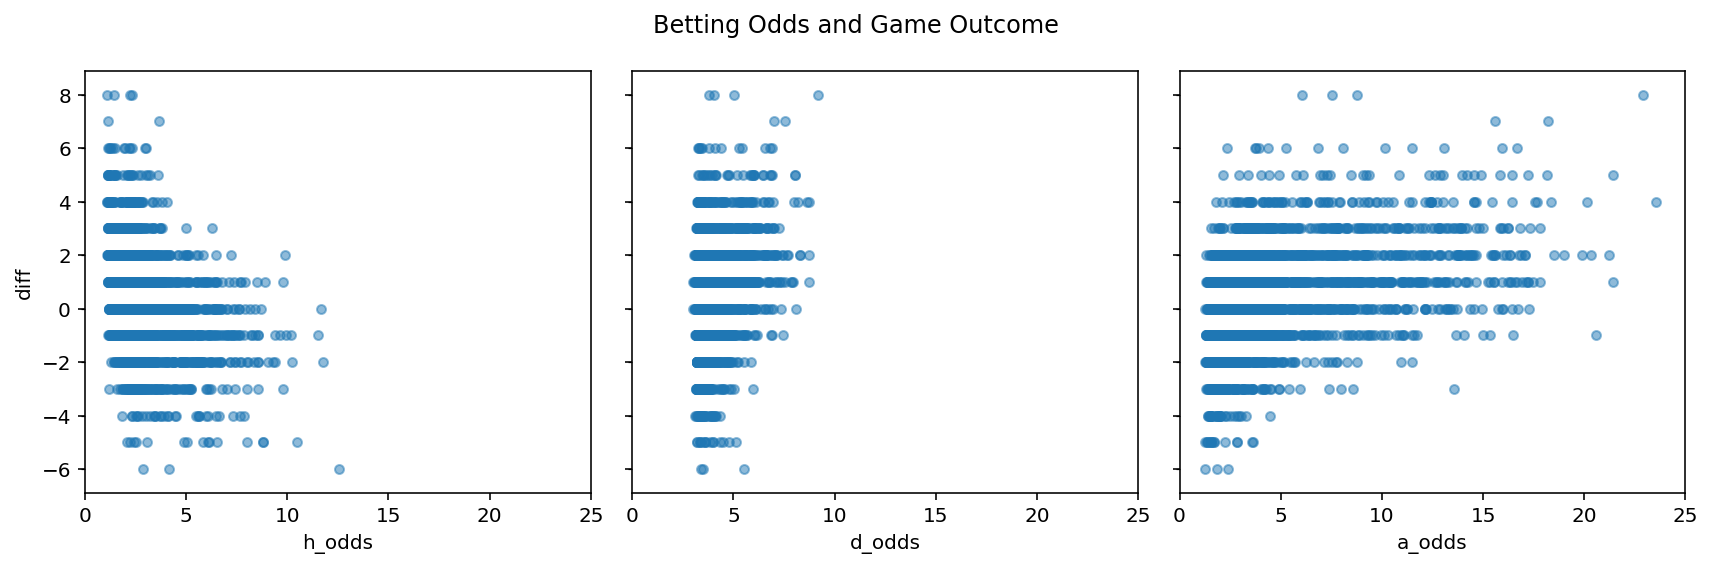

In [6]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4), sharey = True)
for xcol, ax in zip(['h_odds', 'd_odds', 'a_odds'], ax):
    m.plot(kind='scatter', x=xcol, y='diff', ax=ax, alpha=0.5)
    ax.set_xlim(0,25)

f.suptitle('Betting Odds and Game Outcome')
f.tight_layout()
f.subplots_adjust(top=0.88)

As seen there is the expected correlation in the home and away betting odds graphs, wherein with decreased (better) odds the goal difference increases in favour of the team with better odds.

This however does not accuratelly portray how often they predict correctly, a 2d histogram better shows this.

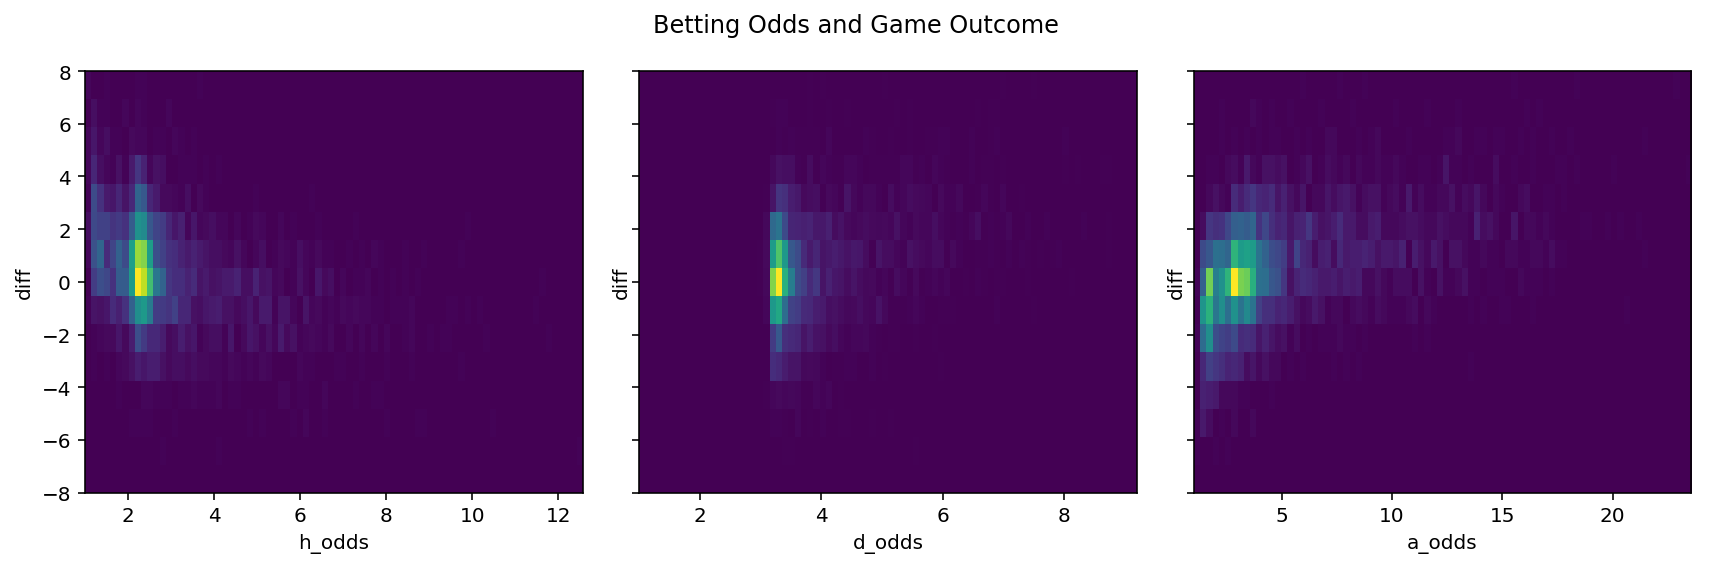

In [7]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4), sharey = True)
for xcol, ax in zip(['h_odds', 'd_odds', 'a_odds'], ax):
    ax.hist2d(m[xcol], m['diff'], bins=(80, 15),  range=np.array([(1, m[xcol].max()), (-8,8)]))
    ax.set_xlabel(xcol)
    ax.set_ylabel('diff')
f.suptitle('Betting Odds and Game Outcome')
f.tight_layout()
f.subplots_adjust(top=0.88)

As seen there are many more points located around 2.5 for h_odds and a_odds and a the game outcomes can be seen to peak at 0 (a draw). The densities here reinforce the expected correlation.

This can be taken further by finding a linear regression, which can be performed natively in seaborne.

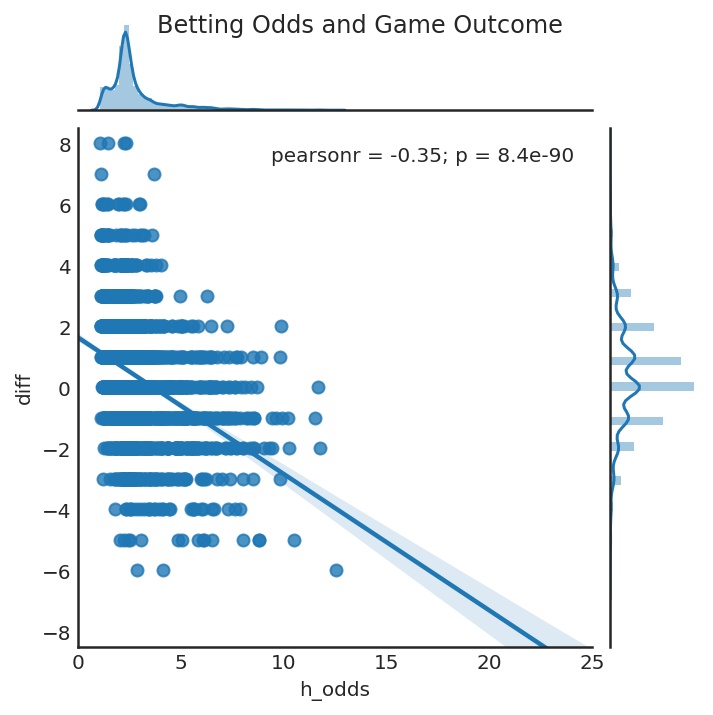

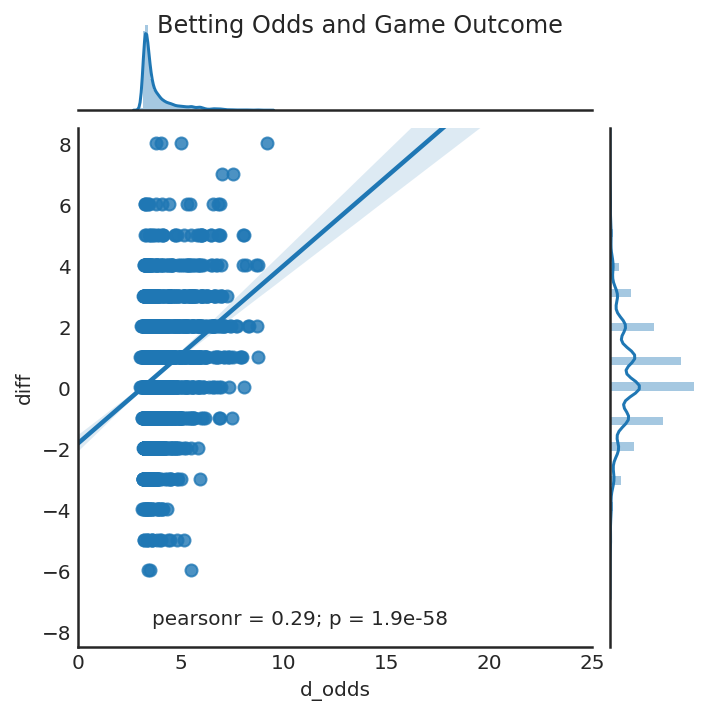

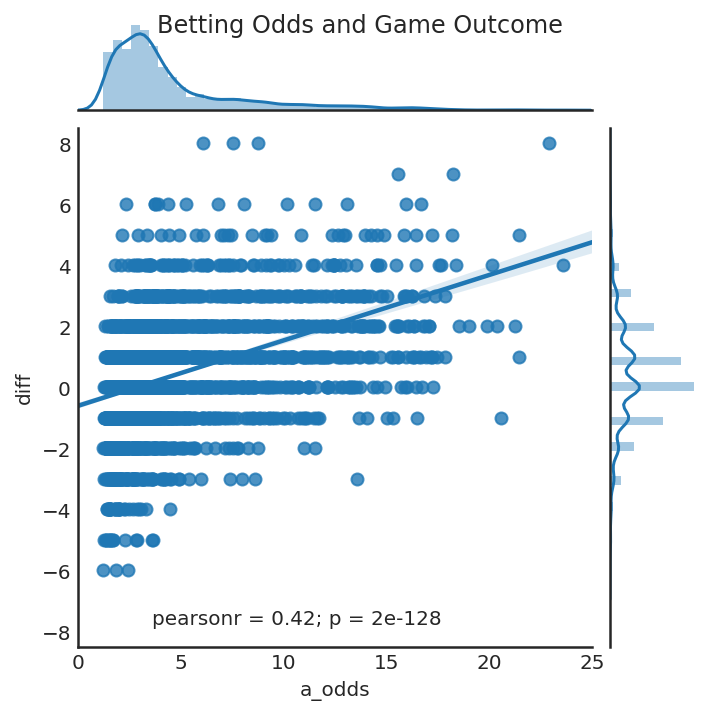

In [8]:
for xcol in ['h_odds', 'd_odds', 'a_odds']:
    with sns.axes_style("white"):
        sns.jointplot(x=m[xcol], y=m['diff'], kind="reg", size = 5, xlim=(0,25), ylim=(-8.5,8.5));
        plt.suptitle('Betting Odds and Game Outcome')

As seen in the pearsonr values the strongest correlation is between away odds and goal difference, followed by home odds. This might imply that away odds are a better representation of the probable outcome, or rather that the wider distribution of away odds lends to catching large home wins more often.

These regression scores and the linear fit values are also found below for confirmation ($R$ values have been changed into $R^2$ values.)

In [9]:
regr_h = linear_model.LinearRegression()
regr_a = linear_model.LinearRegression()
regr_h.fit(m['h_odds'].values.reshape(-1, 1), m['diff'].values.reshape(-1, 1))
regr_a.fit(m['a_odds'].values.reshape(-1, 1), m['diff'].values.reshape(-1, 1))

print('home', regr_h.coef_, regr_h.intercept_, regr_h.score(m['h_odds'].values.reshape(-1, 1), m['diff'].values.reshape(-1, 1)))
print('away', regr_a.coef_, regr_a.intercept_, regr_a.score(m['a_odds'].values.reshape(-1, 1), m['diff'].values.reshape(-1, 1)))

home [[-0.44756653]] [ 1.63694252] 0.124466267766
away [[ 0.21465043]] [-0.60704862] 0.17415287197


As mentioned above away odds appear to have a wider distribution, where h_odds have a much higher density at the mean than a_odds.

The below graph illustrates how home odds tend to be distibuted around 2.5 whereas a_odds have a wider spread.

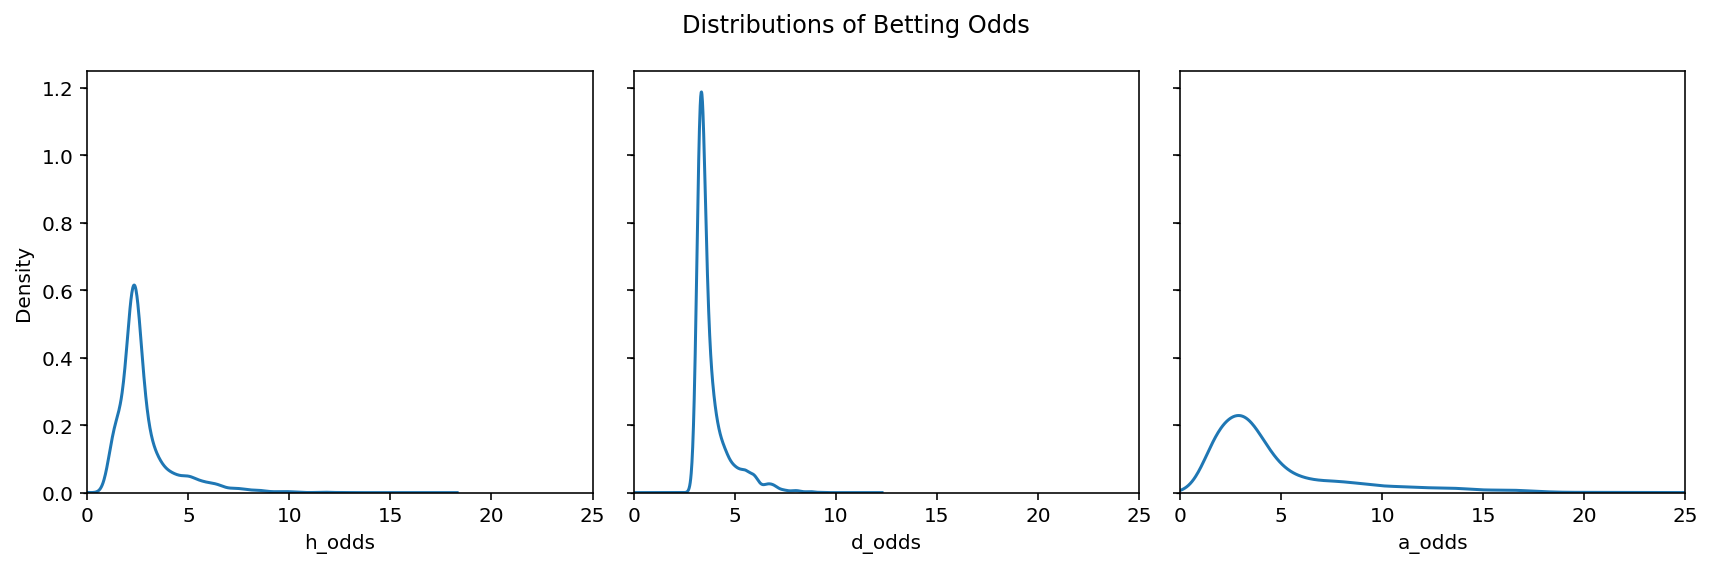

In [10]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4), sharey = True)
for xcol, ax in zip(['h_odds', 'd_odds', 'a_odds'], ax):
    m[xcol].plot(kind='kde', y = xcol, ax=ax)
    ax.set_xlabel(xcol)
    ax.set_xlim(0,25)
    ax.set_ylim(0,1.25)
f.suptitle('Distributions of Betting Odds')
f.tight_layout()
f.subplots_adjust(top=0.88)

The above graph also reveals the almost perfect uniformity of draw odds as they have such a sharp peak.

Moving on we will look at the occurences of correct predicitons. A correct prediction is seen as where the betting odds for that outcome are the lowest of all three possible outcomes (home win/draw/away win).

The naming convention is where the first letter is the prediction and the second is the outcome (a predicted home win with an away win outcome would be h_a.)

Draw predictions are not in the list of conditions as (in this selection) they are never predicted.

In [11]:
conditions = [
    (m['diff'] > 0) & (m['h_odds'] < m['a_odds']) & (m['h_odds'] < m['d_odds']),
    (m['diff'] == 0) & (m['h_odds'] < m['a_odds']) & (m['h_odds'] < m['d_odds']),
    (m['diff'] < 0) & (m['h_odds'] < m['a_odds']) & (m['h_odds'] < m['d_odds']),
    (m['diff'] < 0) & (m['a_odds'] < m['h_odds']) & (m['a_odds'] < m['d_odds']),
    (m['diff'] == 0) & (m['a_odds'] < m['h_odds']) & (m['a_odds'] < m['d_odds']),
    (m['diff'] > 0) & (m['a_odds'] < m['h_odds']) & (m['a_odds'] < m['d_odds']),
    (m['diff'] == 0) & (m['d_odds'] < m['h_odds']) & (m['d_odds'] < m['a_odds']),
    (m['diff'] > 0) & (m['d_odds'] < m['h_odds']) & (m['d_odds'] < m['a_odds']),
    (m['diff'] < 0) & (m['d_odds'] < m['h_odds']) & (m['d_odds'] < m['a_odds'])]
choices = ['h_h', 'h_d', 'h_a', 'a_a', 'a_d', 'a_h', 'd_d', 'd_h', 'd_a']
m['correct_odds'] = np.select(conditions, choices)
m.head()

,season,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,goal,B365H,B365D,...,GBD,GBA,BSH,BSD,BSA,h_odds,d_odds,a_odds,diff,correct_odds
0,2008/2009,2008-08-17 00:00:00,489042,10260,10261,1,1,<goal><value><comment>n</comment><stats><goals...,1.29,5.5,...,4.75,10.0,1.29,4.50,11.00,1.28250,4.822222,10.083333,0,h_d
1,2008/2009,2008-08-16 00:00:00,489043,9825,8659,1,0,<goal><value><comment>n</comment><stats><goals...,1.20,6.5,...,5.50,13.0,1.22,5.00,13.00,1.21375,5.522222,12.222222,1,h_h
2,2008/2009,2008-08-16 00:00:00,489044,8472,8650,0,1,<goal><value><comment>n</comment><stats><goals...,5.50,3.6,...,3.40,1.7,4.50,3.40,1.73,4.85375,3.450000,1.671111,-1,a_a
3,2008/2009,2008-08-16 00:00:00,489045,8654,8528,2,1,<goal><value><comment>n</comment><stats><goals...,1.91,3.4,...,3.25,4.0,1.91,3.25,3.80,1.88000,3.283333,3.938889,1,h_h
4,2008/2009,2008-08-17 00:00:00,489046,10252,8456,4,2,<goal><value><comment>n</comment><stats><goals...,1.91,3.4,...,3.25,4.0,1.91,3.30,3.75,1.91500,3.277778,3.814444,2,h_h


The below graph will show what outcome is both most predicted (and how accurately), and most common.

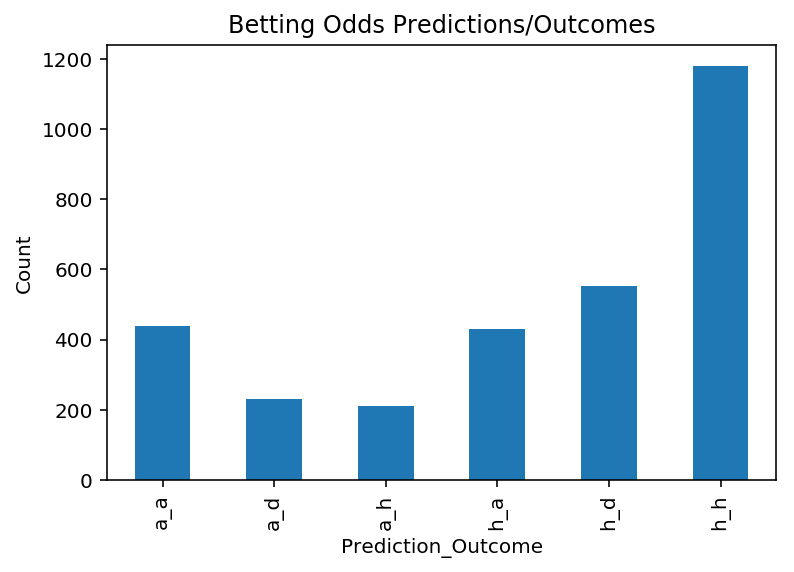

In [12]:
ax = m['correct_odds'].value_counts().sort_index().plot(kind='bar', title='Betting Odds Predictions/Outcomes')
ax.set_ylabel('Count')
ax.set_xlabel('Prediction_Outcome');

In [13]:
m['correct_odds'].value_counts().sort_index()

a_a     438
a_d     231
a_h     210
h_a     429
h_d     552
h_h    1180
Name: correct_odds, dtype: int64

Home wins are by far the most common outcome at 1390 count followed by away wins at 867 count.

As seen home wins are the most frequently predicted outcome with an accuracy of $\frac{1180}{1180+552+429} = .546$ or $54.6\%$. Away wins are predicted with an accuracy of $\frac{438}{428+231+210} = .504$ or $50.4\%$.

### Match Outcomes
And just quickly for interest a look at the outcomes of matches.

Here we will look to plot home team goals against away team to find a heatmap of outcomes. To do this a pivot table is created from home and away goals.

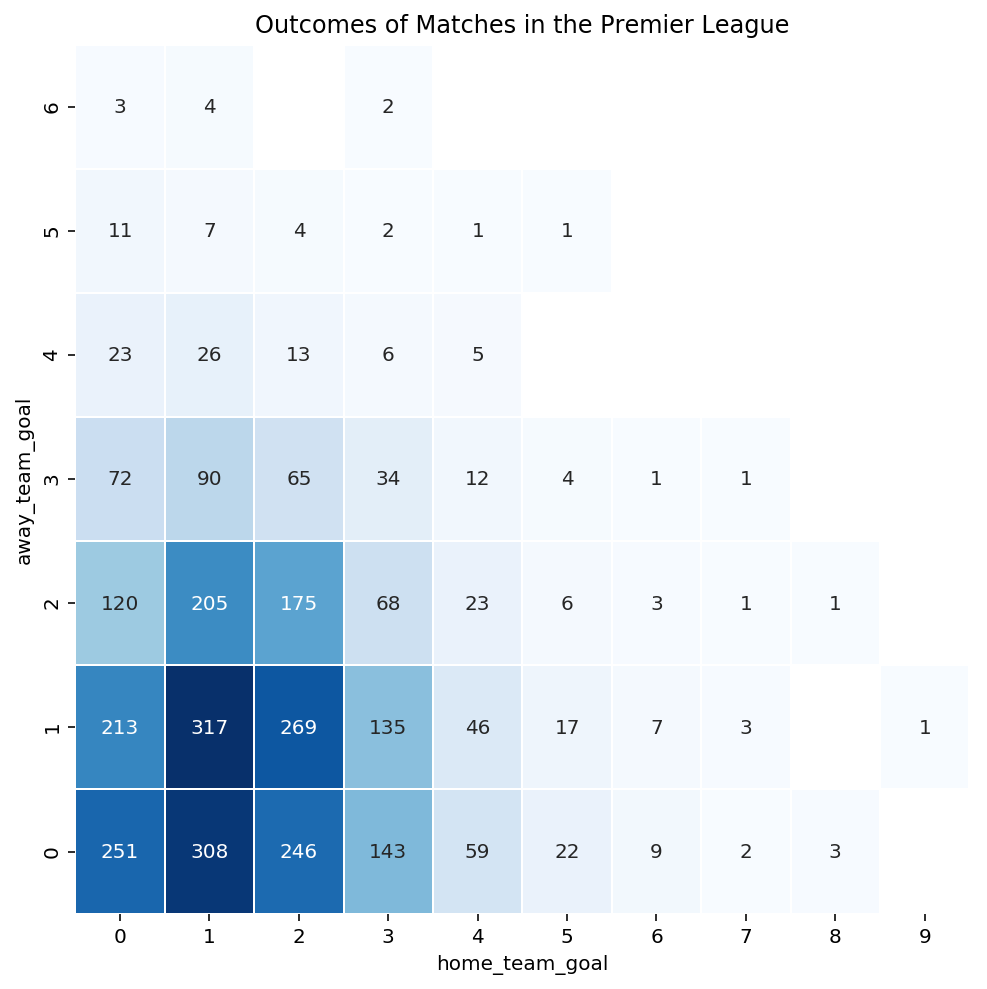

In [14]:
pivot = m[['home_team_goal', 'away_team_goal']].groupby(['home_team_goal', 'away_team_goal'])\
                    .size().reset_index(name='count')\
                    .pivot(index='away_team_goal', columns='home_team_goal', values='count')

fig, ax = plt.subplots(figsize=(7,7))
ax = sns.heatmap(pivot, cmap='Blues', cbar=False, linewidths=.5, annot = True, fmt='.0f')
ax.invert_yaxis()
ax.set_title('Outcomes of Matches in the Premier League')
fig.tight_layout()

Interestingly the most common outcome is a 1-1 draw, and we find that home teams are more likley to score 4 or more goals.

A sum of the diagonals would show the distribution of goal differences seen in the above section.

## Exploring Premier League Goal Data

The goal data contains many interesting traits which can be used to explore for example the deadliest peanalty takers.

The data is stored as XML as seen below so we import ElementTree to access it.

In [15]:
import xml.etree.ElementTree as ET

In [16]:
print(m['goal'][8])

<goal><value><comment>n</comment><stats><goals>1</goals><shoton>1</shoton></stats><event_incident_typefk>406</event_incident_typefk><elapsed>9</elapsed><player2>24843</player2><subtype>header</subtype><player1>34248</player1><sortorder>1</sortorder><team>9879</team><id>376153</id><n>231</n><type>goal</type><goal_type>n</goal_type></value><value><comment>n</comment><stats><goals>1</goals><shoton>1</shoton></stats><event_incident_typefk>407</event_incident_typefk><elapsed>23</elapsed><player2>34430</player2><subtype>distance</subtype><player1>39073</player1><sortorder>1</sortorder><team>8667</team><id>376379</id><n>243</n><type>goal</type><goal_type>n</goal_type></value><value><comment>n</comment><stats><goals>1</goals><shoton>1</shoton></stats><event_incident_typefk>393</event_incident_typefk><elapsed>82</elapsed><player2>23034</player2><subtype>shot</subtype><player1>23563</player1><sortorder>1</sortorder><team>8667</team><id>377500</id><n>295</n><type>goal</type><goal_type>n</goal_typ

We will make the g (goal) dataframe by iterating over each goal cell, and finding the interesting elements. For each event a new row is created in the goal table.

In [17]:
columns=['match_api_id', 'team_api_id', 'score_id', 'assist_id','goal_type', 'goal_subtype','time']
g = pd.DataFrame(columns = columns)
for index, row in m.iterrows():
    goal_data = ET.fromstring(row['goal'])
    current_row = len(g)
    for value in goal_data.iterfind('value'):
        g.loc[current_row, 'match_api_id'] = row['match_api_id']
        current_col = 1
        for data_point in ['id', 'player1', 'player2', 'goal_type', 'subtype', 'elapsed']:
            if value.find(data_point) is not None:
                g.loc[current_row, columns[current_col]] = value.find(data_point).text
            current_col += 1
        current_row += 1

In [18]:
g.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8634 entries, 0 to 8633
Data columns (total 7 columns):
match_api_id    8634 non-null object
team_api_id     8634 non-null object
score_id        8603 non-null object
assist_id       5856 non-null object
goal_type       8626 non-null object
goal_subtype    7654 non-null object
time            8634 non-null object
dtypes: object(7)
memory usage: 859.6+ KB


As seen there are some missing values. Many assist_ids are missing, however this is expected as there are solo goals. Some goal_type and goal_subtypes are missing, the more significant here is goal_type as certain events are not infact goals ([Kaggle Discussion](https://www.kaggle.com/timon88/extracting-goal-times/comments#135870)) as such it is important to keep this in mind when looking at scorer data.

In [19]:
g[['match_api_id', 'team_api_id', 'time']]  \
    = g[['match_api_id', 'team_api_id', 'time']].apply(pd.to_numeric, downcast='integer')

We want to attach the player names to this data so a p (player) dataframe is collected from the database.

In [20]:
con = sq.connect('./database.sqlite')
p = pd.read_sql_query("SELECT player_api_id, player_name FROM Player" ,con)
p['player_api_id'] = p['player_api_id'].astype('str')

Here we left merge the scorer names on the player_api_id and then the assist names.

In [21]:
g_p_temp = pd.merge(g,p, how='left', left_on=['score_id'], right_on=['player_api_id'])
g_p_temp = g_p_temp.drop('player_api_id', axis=1)
g_p_temp.rename(columns={'player_name': 'score_name'}, inplace=True)

g_p = pd.merge(g_p_temp,p, how='left', left_on=['assist_id'], right_on=['player_api_id'])
g_p = g_p.drop('player_api_id', axis=1)
g_p.rename(columns={'player_name': 'assist_name'}, inplace=True)

In [22]:
g_p.head()

,match_api_id,team_api_id,score_id,assist_id,goal_type,goal_subtype,time,score_name,assist_name
0,489042,378998,37799,38807,n,header,22,Obafemi Martins,James Milner
1,489042,379019,24148,24154,n,shot,24,Darren Fletcher,Ryan Giggs
2,489043,375546,26181,39297,n,shot,4,Samir Nasri,Denilson
3,489044,378041,30853,30889,n,distance,83,Fernando Torres,Xabi Alonso
4,489045,376060,23139,36394,n,shot,4,Dean Ashton,Julien Faubert


Firstly we can take a look at score times, to see if there is any trend over the course of matches as to when goals are scored.

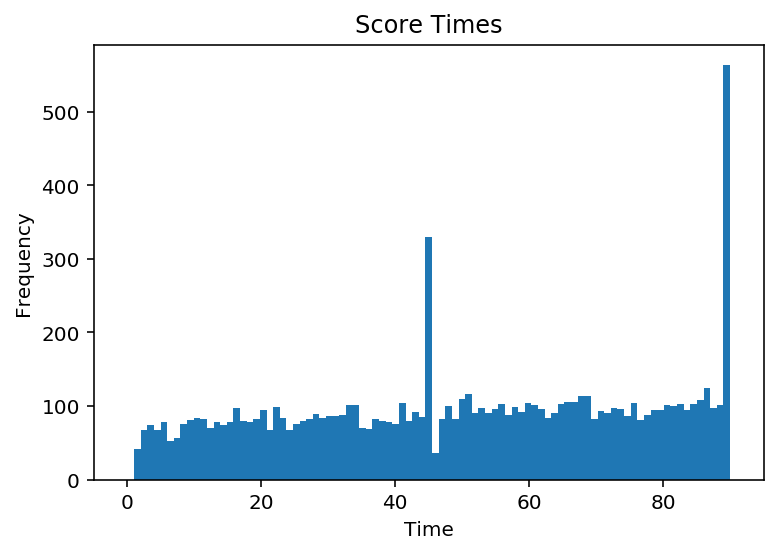

In [23]:
ax = g_p['time'].plot(kind='hist', xlim=(-5,95), title='Score Times', bins=90);
ax.set_xlabel('Time');

From the graph there are two peaks at 45 and 90 mins which can be explained by extra time not being represented, as such the 90th minute will most often last for longer than one minute. Other than that it is quite uniform barring the first minutes of each half.

Next we can have a look at the frequency of types of goals scored.

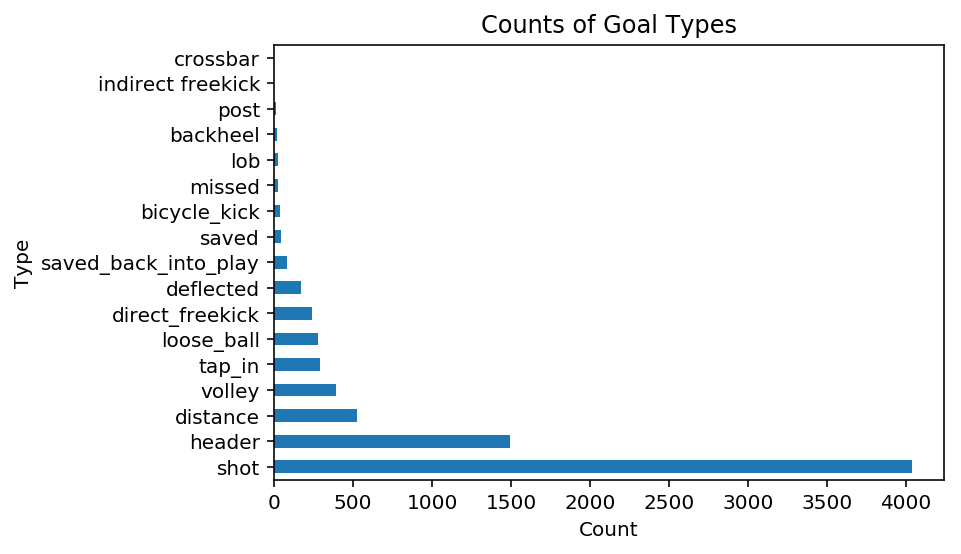

In [24]:
ax = g_p.goal_subtype.value_counts().plot(kind='barh', title='Counts of Goal Types')
ax.set_xlabel('Count')
ax.set_ylabel('Type');

As expected 'shot' is the most common, followed by headers. The saved and missed types illustrate how some of these events are not goals.

So now looking at ones where the goal type is 'n' or 'p' (goal or penalty), which removes these non-goal types seen above, we can quickly see the top goalscorers from 2008/09 to 2015/16.

In [25]:
g_p[g_p['goal_type'].isin(['n','p'])].groupby('score_name').size()\
                    .reset_index(name='count').sort_values('count', ascending=False).head(10)

,score_name,count
843,Wayne Rooney,125
694,Robin van Persie,116
753,Sergio Aguero,102
285,Frank Lampard,82
394,Jermain Defoe,75
510,Luis Suarez,69
189,Darren Bent,68
178,Daniel Sturridge,68
228,Dimitar Berbatov,67
789,Steven Gerrard,65


And the top assisters.

In [26]:
g_p[g_p['goal_type'].isin(['n','p'])].groupby('assist_name')['goal_type'].size()\
                    .reset_index(name='count').sort_values('count', ascending=False).head(10)

,assist_name,count
141,Cesc Fabregas,60
222,David Silva,60
878,Wayne Rooney,58
375,James Milner,57
730,Robin van Persie,50
508,Leighton Baines,48
823,Steven Gerrard,47
93,Ashley Young,44
638,Nani,42
298,Frank Lampard,42


And the top peanalty scorers. Note we also bring 'npm' - missed penalty and 'psm' - saved penalty into the pens dataframe in order to calculate the conversion percentage.

In [27]:
pens = g_p[g_p['goal_type'].isin(['p','npm', 'psm'])].groupby('score_name')['goal_type'].value_counts()\
                    .reset_index(name='count')\
                    .sort_values('count', ascending=False)
pens.head()

,score_name,goal_type,count
91,Frank Lampard,p,25
255,Steven Gerrard,p,25
264,Wayne Rooney,p,19
162,Leighton Baines,p,15
174,Mark Noble,p,15


And now on a playerwise basis we'll flatten the pens dataframe into pens_f which groups each type by the player.

In [28]:
columns=['score_name', 'p', 'npm', 'psm']
pens_f = pd.DataFrame(columns = columns)

current_row = len(pens_f)
for player in pens['score_name'].unique():
    pens_f.loc[current_row,'score_name'] = player
    for pen_type in pens[pens['score_name'] == player]['goal_type'].unique():
        pens_f.loc[current_row, pen_type] = int(pens[(pens['score_name']==player) & (pens['goal_type']==pen_type)]['count'])
    current_row += 1

pens_f = pens_f.fillna(0)

And we can now calculate total attempts and conversion percentage.

In [29]:
pens_f['total_attempts'] = pens_f['p'] + pens_f['npm'] + pens_f['psm']
pens_f['conversion_percentage'] = pens_f['p'] / pens_f['total_attempts'] * 100

We can now look at the most clinical penalty takers who have taken 5 or more penalties.

In [30]:
pens_f[pens_f['total_attempts']>4].sort_values('conversion_percentage', ascending = False).head(15)

,score_name,p,npm,psm,total_attempts,conversion_percentage
18,Rickie Lambert,7,0,0,7,100.000000
13,Yaya Toure,9,0,0,9,100.000000
33,Jordi Gomez,5,0,0,5,100.000000
32,Mario Balotelli,5,0,0,5,100.000000
15,Dimitar Berbatov,8,0,0,8,100.000000
20,Graham Alexander,6,0,0,6,100.000000
12,Danny Murphy,10,0,0,10,100.000000
3,Leighton Baines,15,1,0,16,93.750000
14,Eden Hazard,9,1,0,10,90.000000
16,Harry Kane,7,1,0,8,87.500000


We can then find the average conversion percentage by plotting a pie chart below.

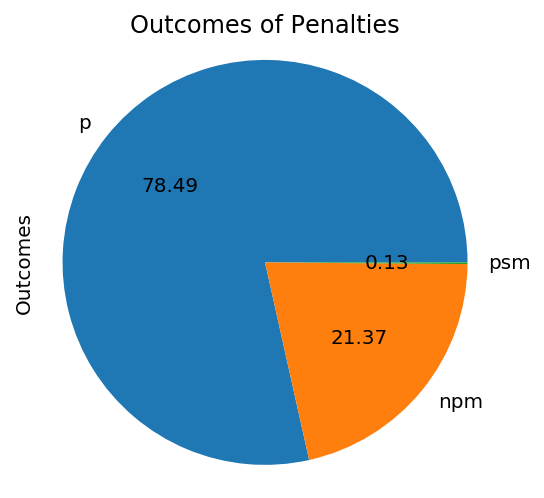

In [31]:
f, ax = plt.subplots(figsize=(4, 4))
pens_f[['p', 'npm', 'psm']].sum().plot(kind='pie', autopct='%.2f', ax=ax, title='Outcomes of Penalties');
plt.axis('equal');
ax.set_ylabel('Outcomes');

There is a 78.49% penalty conversion rate in the league with only 0.13% being saved (this low percentage might imply that some saves are recorded as misses.)

## Team Atributes

Finally we'll look at the fifa team attributes and compare these to the real records of these teams. As play style changes year to year this exploration will only use match data from 2015/16, the most current data.

The ta (team attributes) dataframe attaches the team name to the team attributes table.

In [32]:
ta = pd.read_sql_query("SELECT t.*, Team.team_long_name FROM Team_Attributes t \
                      JOIN Team ON t.team_api_id = Team.team_api_id \
                      group by t.team_api_id", con)
ta.head()

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass,team_long_name
0,1118,874,1601,2015-09-10 00:00:00,47,Balanced,48.0,Normal,38,Mixed,...,Normal,Organised,43,Medium,44,Press,49,Normal,Cover,Ruch Chorzów
1,943,100087,1773,2014-09-19 00:00:00,52,Balanced,51.0,Normal,50,Mixed,...,Normal,Organised,43,Medium,44,Press,50,Normal,Cover,Oud-Heverlee Leuven
2,624,110745,1957,2015-09-10 00:00:00,66,Balanced,54.0,Normal,38,Mixed,...,Normal,Organised,57,Medium,56,Press,49,Normal,Cover,Jagiellonia Białystok
3,932,111540,2033,2014-09-19 00:00:00,45,Balanced,62.0,Normal,40,Mixed,...,Normal,Organised,37,Medium,24,Contain,44,Normal,Cover,S.C. Olhanense
4,700,873,2182,2015-09-10 00:00:00,57,Balanced,50.0,Normal,40,Mixed,...,Lots,Free Form,50,Medium,58,Press,45,Normal,Cover,Lech Poznań


And the mt (match team) dataframe calls only pertinent columns from the Match table where the season is 2015/16.

A difference column is calculated again as seen before.

In [33]:
mt = pd.read_sql_query("SELECT season, home_team_api_id, away_team_api_id, \
                    home_team_goal, away_team_goal FROM Match\
                    WHERE season = '2015/2016'", con)
mt['diff'] = mt.home_team_goal - mt.away_team_goal
mt.head()

,season,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,diff
0,2015/2016,9997,8342,2,1,1
1,2015/2016,8571,9985,2,1,1
2,2015/2016,9987,1773,3,1,2
3,2015/2016,8573,8203,3,1,2
4,2015/2016,10000,9994,3,1,2


Here we issue points based on the goal difference as per typical football conventions.

In [34]:
conditions = [
    (mt['diff'] > 0),
    (mt['diff'] == 0),
    (mt['diff'] < 0)]
choices_h = [3, 1, 0]
mt['home_points'] = np.select(conditions, choices_h)
choices_a = [0, 1, 3]
mt['away_points'] = np.select(conditions, choices_a)
mt.head()

,season,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,diff,home_points,away_points
0,2015/2016,9997,8342,2,1,1,3,0
1,2015/2016,8571,9985,2,1,1,3,0
2,2015/2016,9987,1773,3,1,2,3,0
3,2015/2016,8573,8203,3,1,2,3,0
4,2015/2016,10000,9994,3,1,2,3,0


Two temporary dataframes are called from grouping by home and away team id's summing the points gained and the number of matches they faced at home/away.

These two are then inner merged producing the tp (team points) composite dataframe giving each teams name and their home and away points.

In [35]:
mt_hp = mt.groupby(['home_team_api_id'])['home_points'].agg([np.sum, np.ma.count]).reset_index()
mt_ap = mt.groupby(['away_team_api_id'])['away_points'].agg([np.sum, np.ma.count]).reset_index()

In [36]:
tp = pd.merge(mt_hp, mt_ap, how='inner', left_on='home_team_api_id', right_on='away_team_api_id',\
                    left_index = True, suffixes=('_h', '_a'))
tp = tp.drop('away_team_api_id', axis=1)
tp.rename(columns={'home_team_api_id': 'team_api_id'}, inplace=True)

In [37]:
tp.head()

,team_api_id,sum_h,count_h,sum_a,count_a
0,1601,20,15,19,15
1,1773,20,15,9,15
2,1957,21,15,14,15
3,2182,21,15,22,15
4,2186,25,15,20,15


This then allows for easy calculation of points won per game at home/away and overall.

In [38]:
tp['h_ppg'] = tp.sum_h / tp.count_h
tp['a_ppg'] = tp.sum_a / tp.count_a
tp['o_ppg'] = (tp.sum_h + tp.sum_a) / (tp.count_h + tp.count_a)
tp.head()

,team_api_id,sum_h,count_h,sum_a,count_a,h_ppg,a_ppg,o_ppg
0,1601,20,15,19,15,1.333333,1.266667,1.300000
1,1773,20,15,9,15,1.333333,0.600000,0.966667
2,1957,21,15,14,15,1.400000,0.933333,1.166667
3,2182,21,15,22,15,1.400000,1.466667,1.433333
4,2186,25,15,20,15,1.666667,1.333333,1.500000


Allowing us to take a quick look at the distributions of points per game. Where we might expect to see the same home advantage as seen in the premier league.

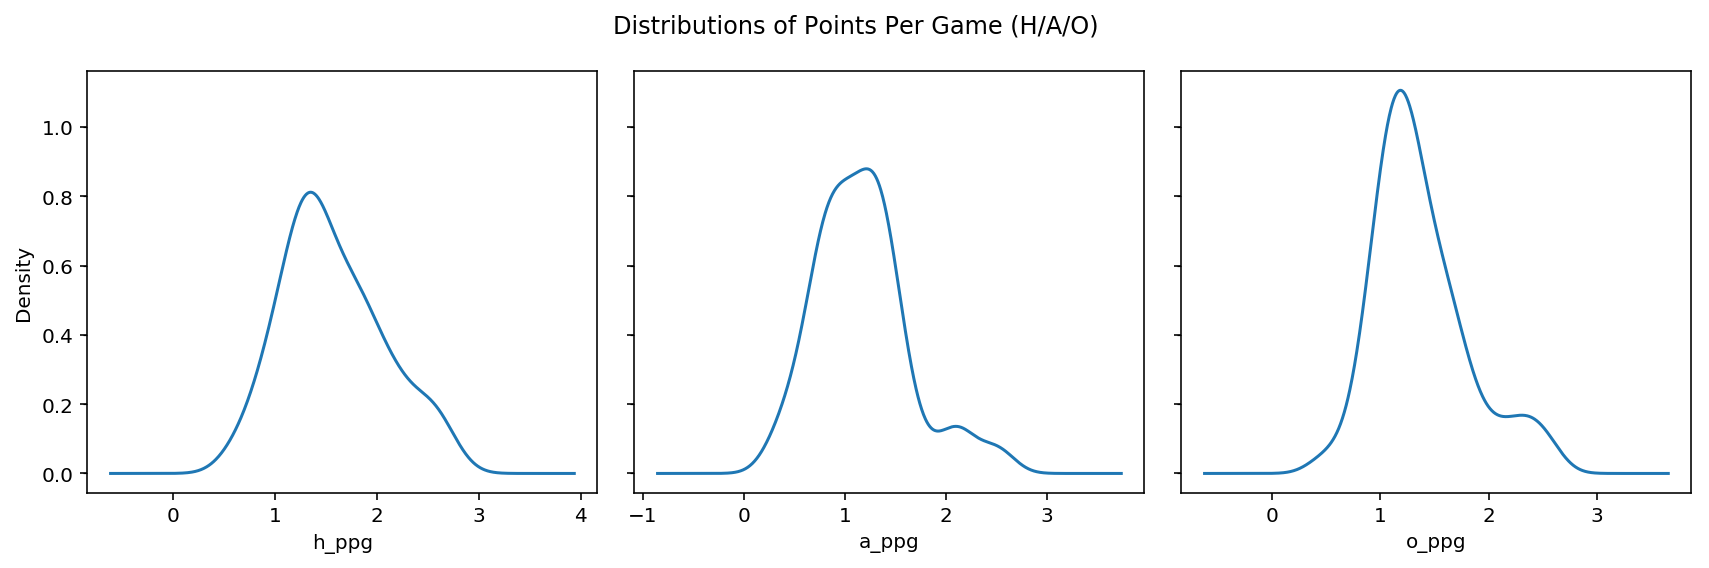

In [39]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), sharey=True)

for xcol, ax in zip(['h_ppg', 'a_ppg', 'o_ppg'], ax):
    tp[xcol].plot(ax=ax, kind='kde')
    ax.set_xlabel(xcol)
    ax.set_ylabel('Density')
f.suptitle('Distributions of Points Per Game (H/A/O)')
f.tight_layout()
f.subplots_adjust(top=0.88)

And as expected the home points per game distribution is more skewed right than away ppg, confirming the home advantage.

Here we merge the last three columns (the points per game) of the tp dataframe to the team attributes, again on team_api_id creating tap dataframe (team attributes points).

In [40]:
tap = pd.merge(ta.iloc[ :, np.r_[2, 4:26]], tp.iloc[ :, np.r_[0, -3:-0]], on = 'team_api_id')
tap.head()

,team_api_id,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,...,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass,team_long_name,h_ppg,a_ppg,o_ppg
0,1601,47,Balanced,48.0,Normal,38,Mixed,Organised,61,Normal,...,Medium,44,Press,49,Normal,Cover,Ruch Chorzów,1.333333,1.266667,1.300000
1,1773,52,Balanced,51.0,Normal,50,Mixed,Organised,50,Normal,...,Medium,44,Press,50,Normal,Cover,Oud-Heverlee Leuven,1.333333,0.600000,0.966667
2,1957,66,Balanced,54.0,Normal,38,Mixed,Organised,53,Normal,...,Medium,56,Press,49,Normal,Cover,Jagiellonia Białystok,1.400000,0.933333,1.166667
3,2182,57,Balanced,50.0,Normal,40,Mixed,Free Form,59,Normal,...,Medium,58,Press,45,Normal,Cover,Lech Poznań,1.400000,1.466667,1.433333
4,2186,37,Balanced,50.0,Normal,38,Mixed,Organised,66,Normal,...,Medium,34,Press,64,Normal,Cover,Cracovia,1.666667,1.333333,1.500000


Which means we can look at the top performing teams in 2015/16.

In [41]:
tap[['team_long_name','o_ppg']].sort_values(by='o_ppg', ascending=False).head()

,team_long_name,o_ppg
99,SL Benfica,2.588235
111,FC Bayern Munich,2.588235
98,Sporting CP,2.529412
120,Paris Saint-Germain,2.526316
82,PSV,2.470588


### Comparing Team Attributes to Real Performance

So now to see if play style can be related to sucsess, the numeric team attributes can be plotted against overall points per game.

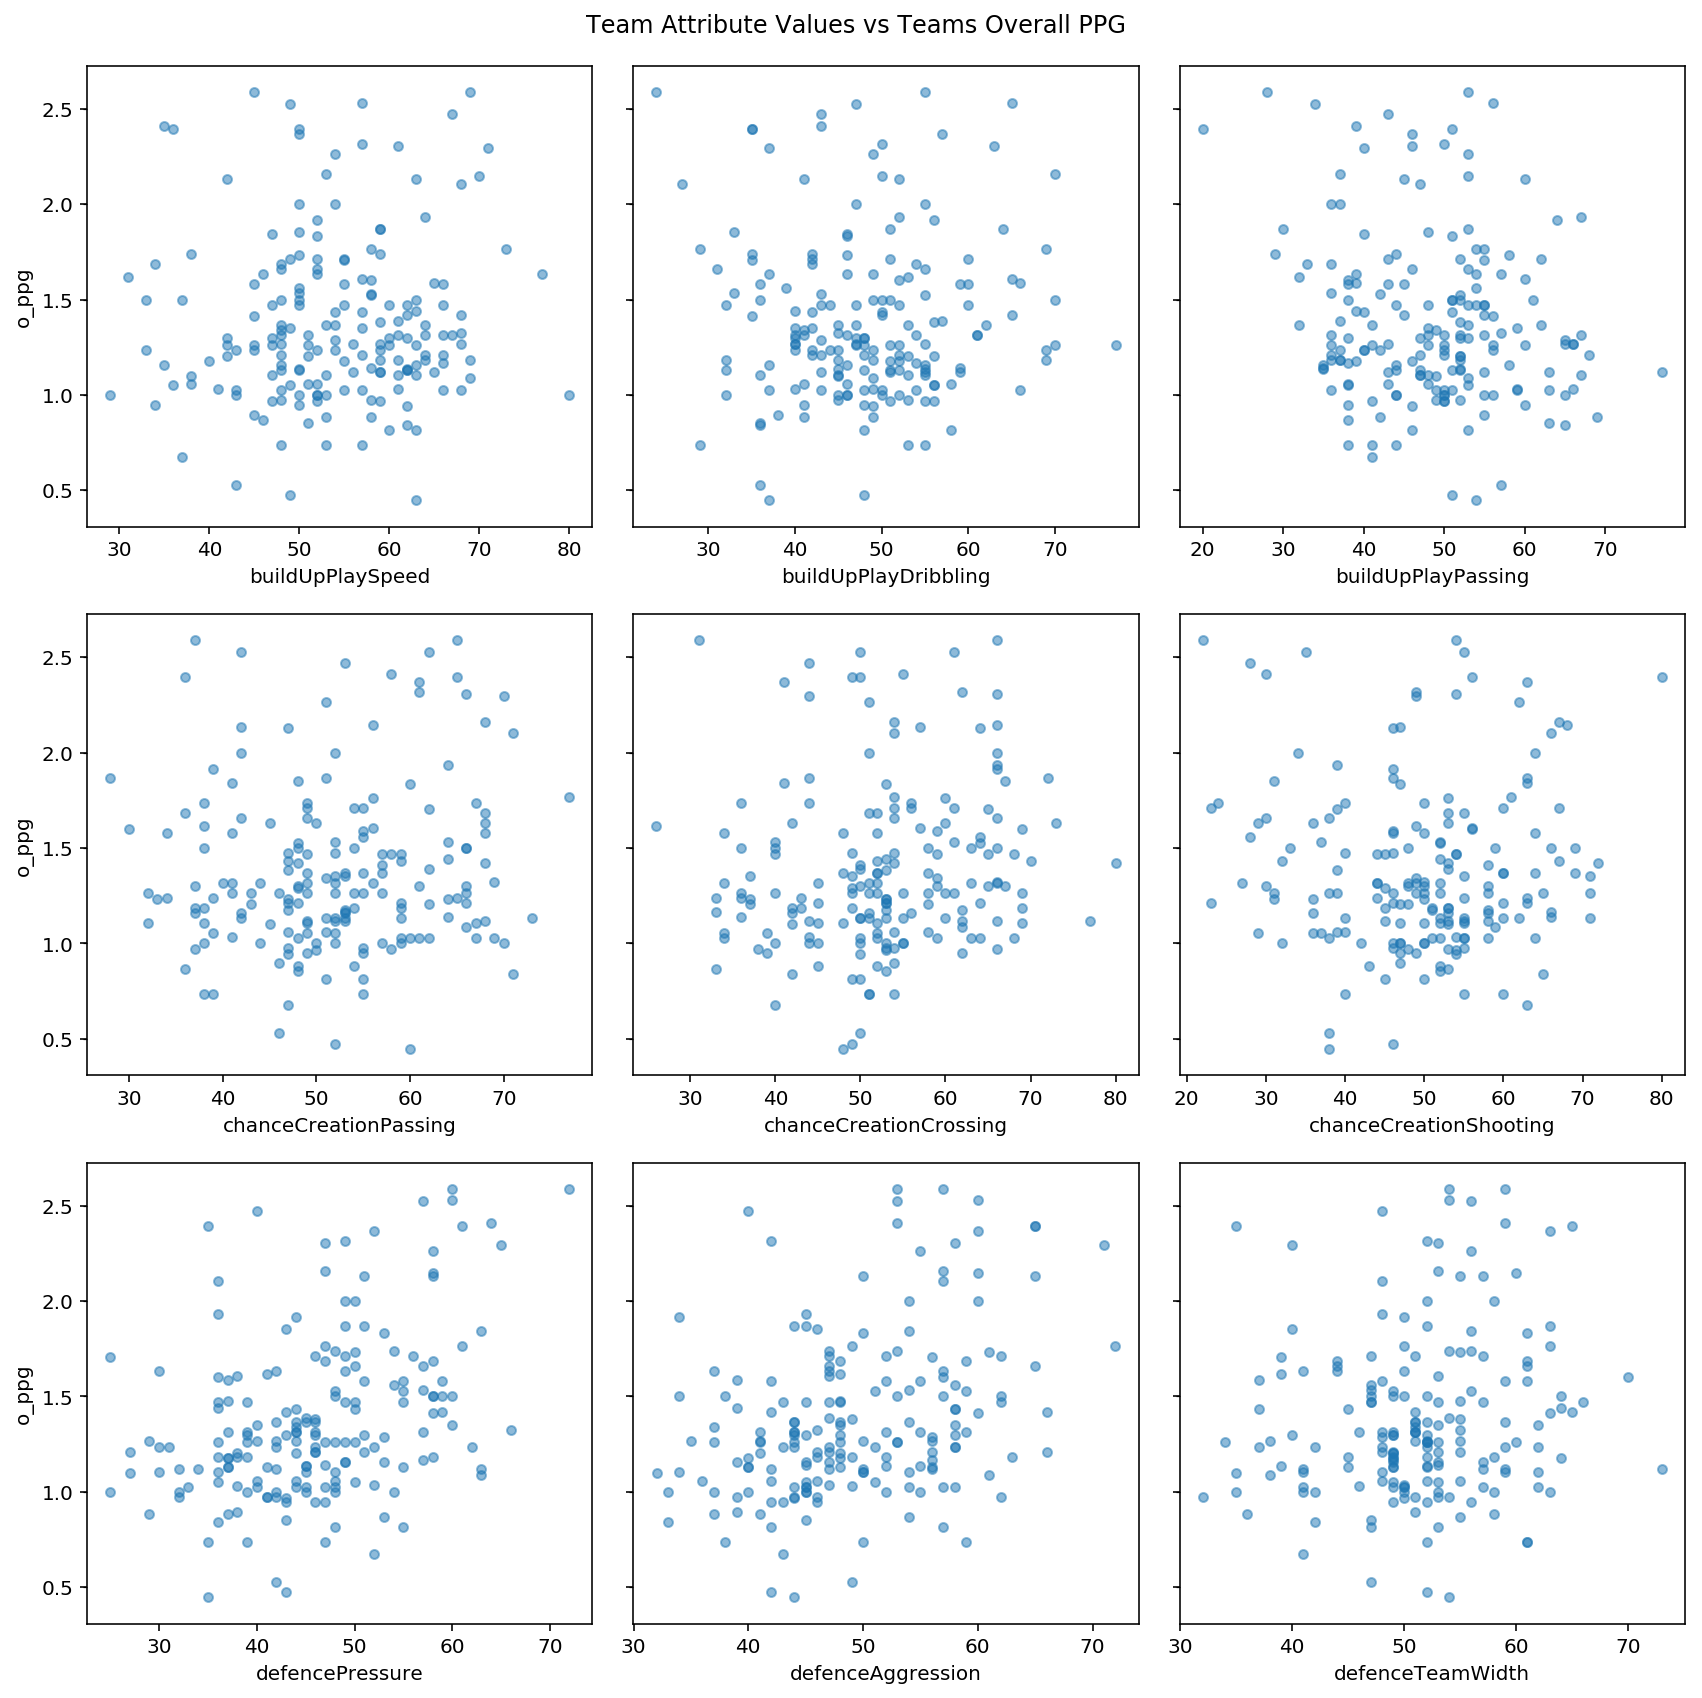

In [42]:
f, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,12), sharey = True)
for xcol, ax in zip(['buildUpPlaySpeed', 'buildUpPlayDribbling', 'buildUpPlayPassing', \
                     'chanceCreationPassing', 'chanceCreationCrossing', 'chanceCreationShooting', \
                     'defencePressure', 'defenceAggression', 'defenceTeamWidth'], ax.reshape(-1)):
    tap.plot(kind='scatter', x=xcol, y='o_ppg', ax=ax, alpha=0.5);
f.suptitle('Team Attribute Values vs Teams Overall PPG')
f.tight_layout()
f.subplots_adjust(top=0.95)

Evidently there is no outright winner in terms of linear relation between any of the strategies and ppg, just to check however the correlation scores are shown below.

In [43]:
tap.corr()['o_ppg']

team_api_id              -0.066257
buildUpPlaySpeed          0.056285
buildUpPlayDribbling      0.006848
buildUpPlayPassing       -0.175857
chanceCreationPassing     0.093591
chanceCreationCrossing    0.141690
chanceCreationShooting   -0.010210
defencePressure           0.389963
defenceAggression         0.362155
defenceTeamWidth          0.144623
h_ppg                     0.904074
a_ppg                     0.887326
o_ppg                     1.000000
Name: o_ppg, dtype: float64

The best strategy seen here is to have defence pressure being higher, followed by increased defence aggression.

We will now lead into comparing the class columns to overall points per game.

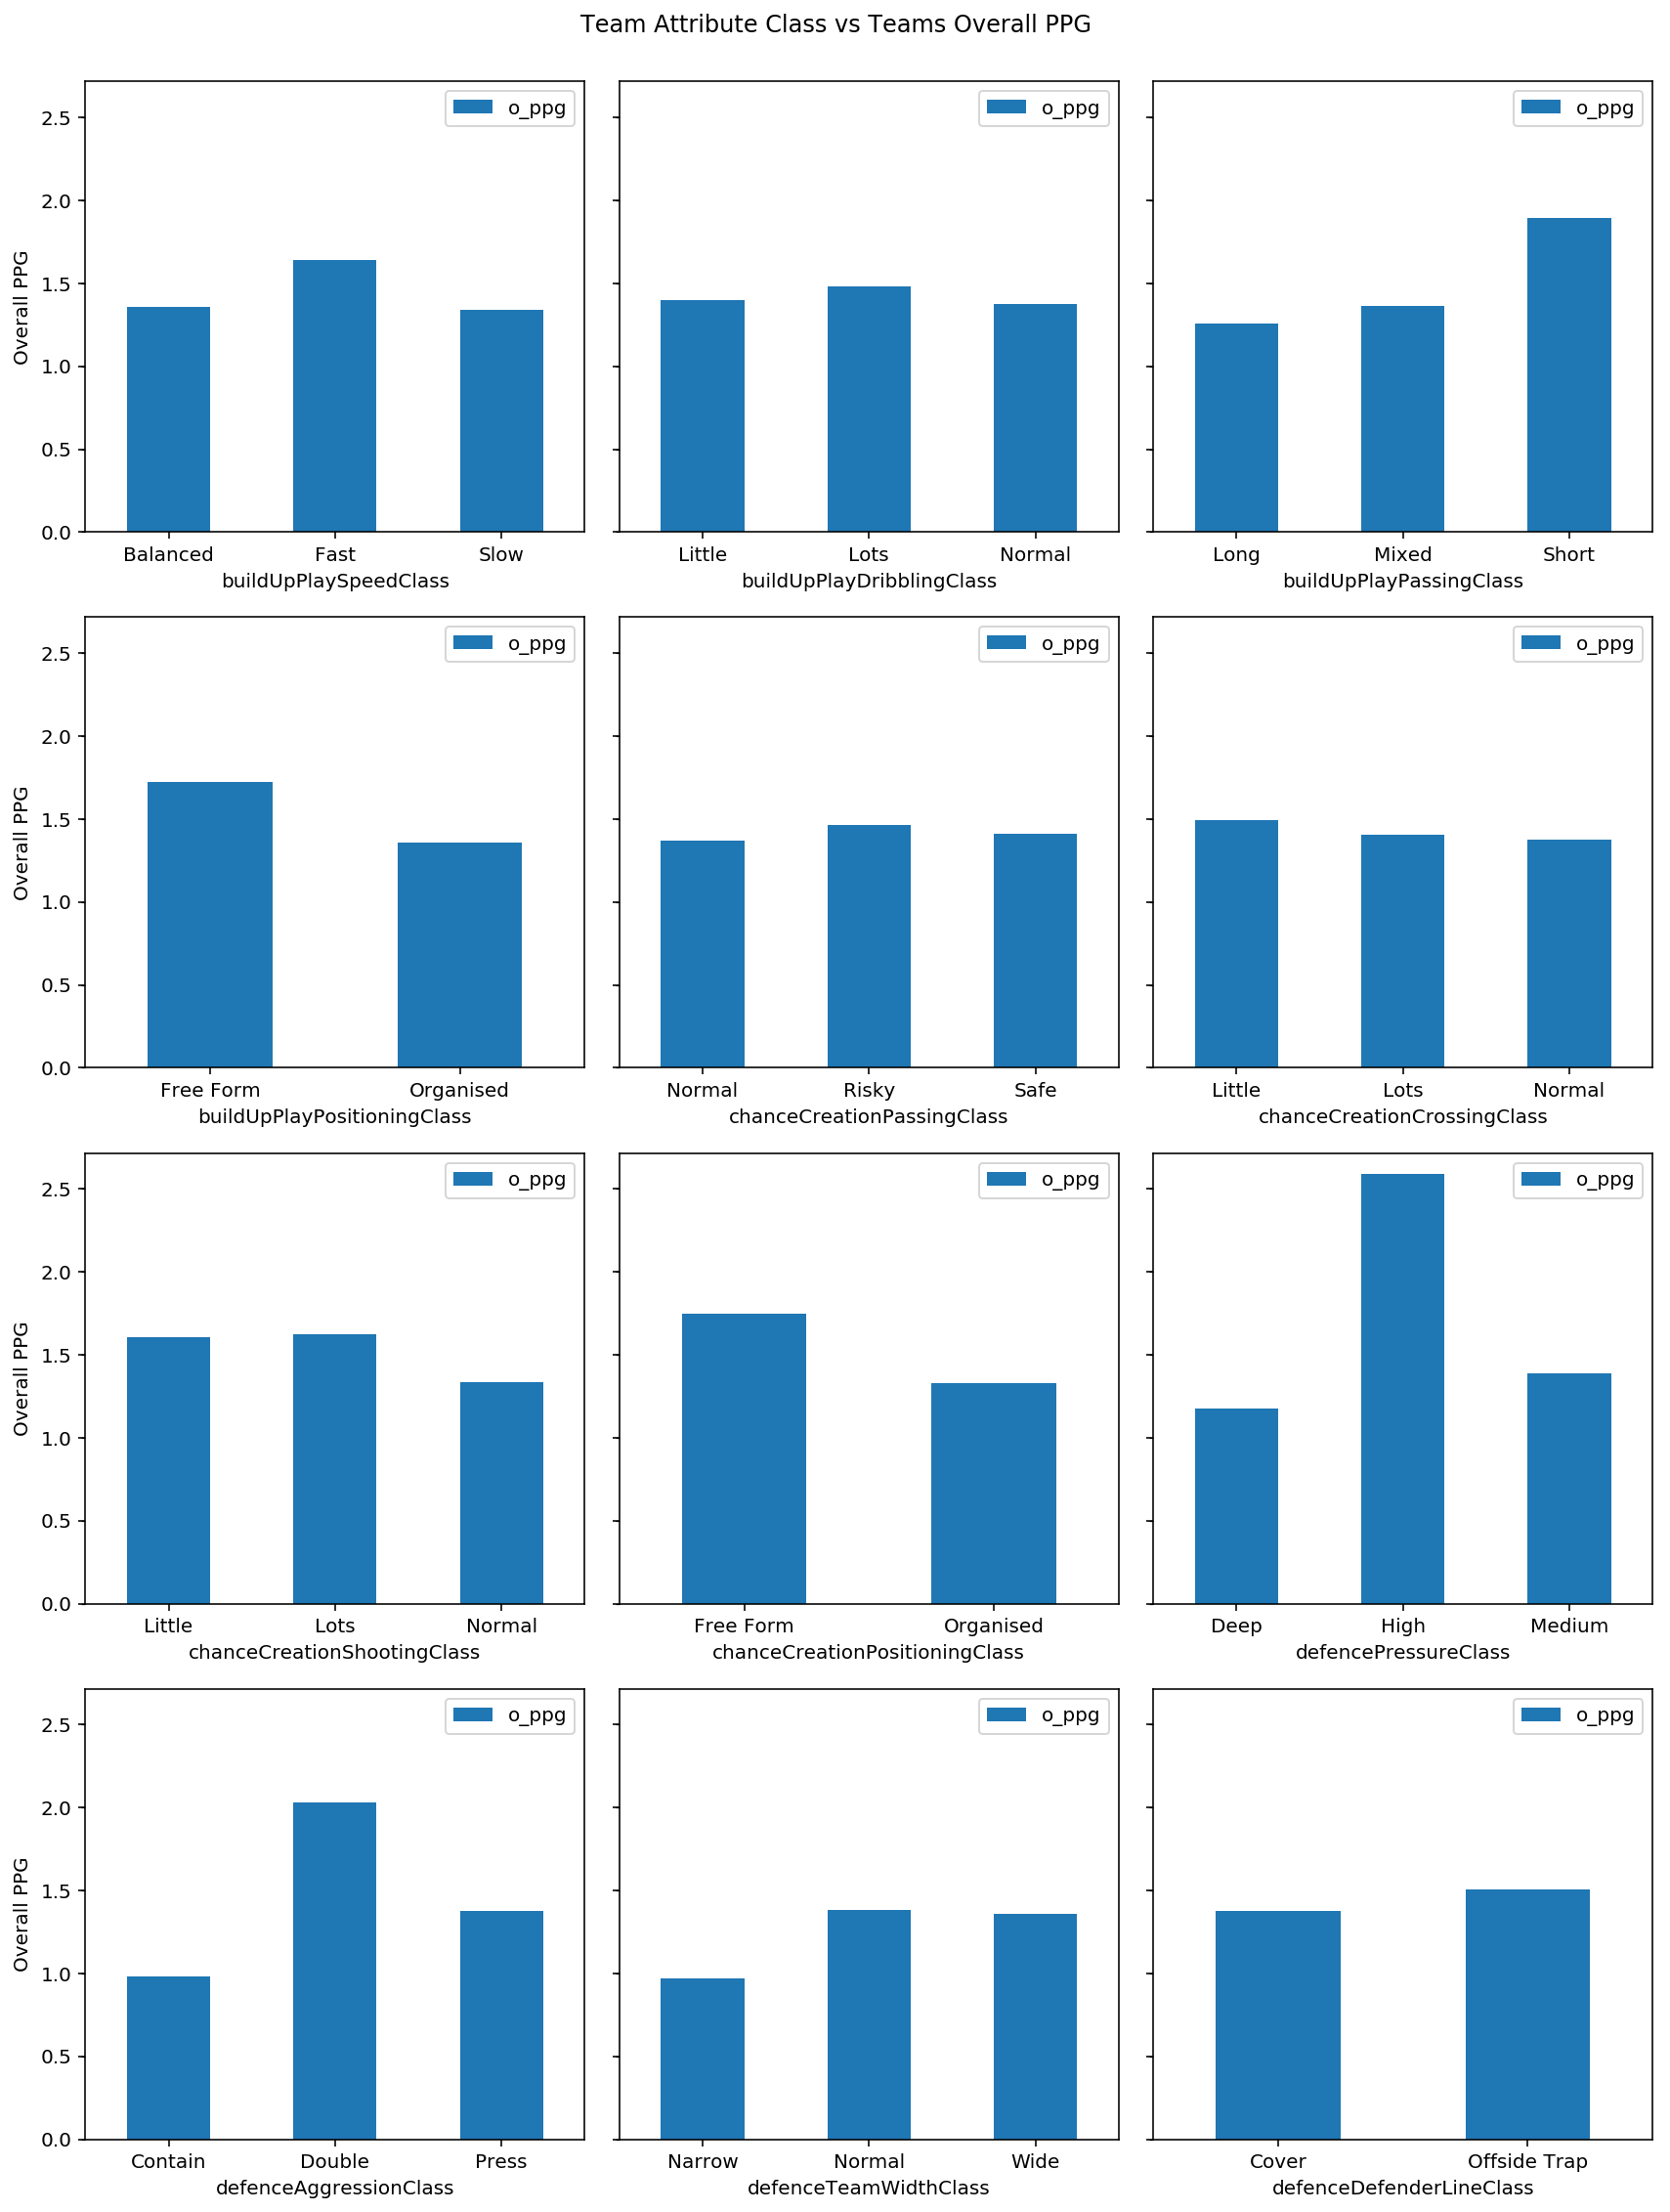

In [44]:
f, ax = plt.subplots(nrows=4, ncols=3, figsize=(12,16), sharey = True)
for xcol, ax in zip(['buildUpPlaySpeedClass', 'buildUpPlayDribblingClass', 'buildUpPlayPassingClass', \
        'buildUpPlayPositioningClass', 'chanceCreationPassingClass', 'chanceCreationCrossingClass', \
        'chanceCreationShootingClass', 'chanceCreationPositioningClass', 'defencePressureClass', \
        'defenceAggressionClass', 'defenceTeamWidthClass', 'defenceDefenderLineClass'], ax.reshape(-1)):
    tap.groupby(xcol)['o_ppg'].mean().reset_index().plot(kind='bar', x=xcol, y='o_ppg', ax=ax, rot=0);
    ax.set_ylabel('Overall PPG')
f.suptitle('Team Attribute Class vs Teams Overall PPG')
f.tight_layout()
f.subplots_adjust(top=0.95)

There are many interesting conclusions from this, but in linking to the numerical attributes the High defencePressureClass and Double defenceAggressionClass again show a clear advantage over the other options; this agrees with the defenceAgression and defencePressure correlations as seen above.

The most promising argument to be taken from this is that having an agressive high pressing defence is most effective in producing results, although the low correlation in the numeric attributes implies it is not so simple.

### Comparing Team Attributes to Each Other

We can now look at the likelihood of certain characteristics being related to others.

The numeric team attributes can be compared by plotting against one another (while also showing the distribution of values).

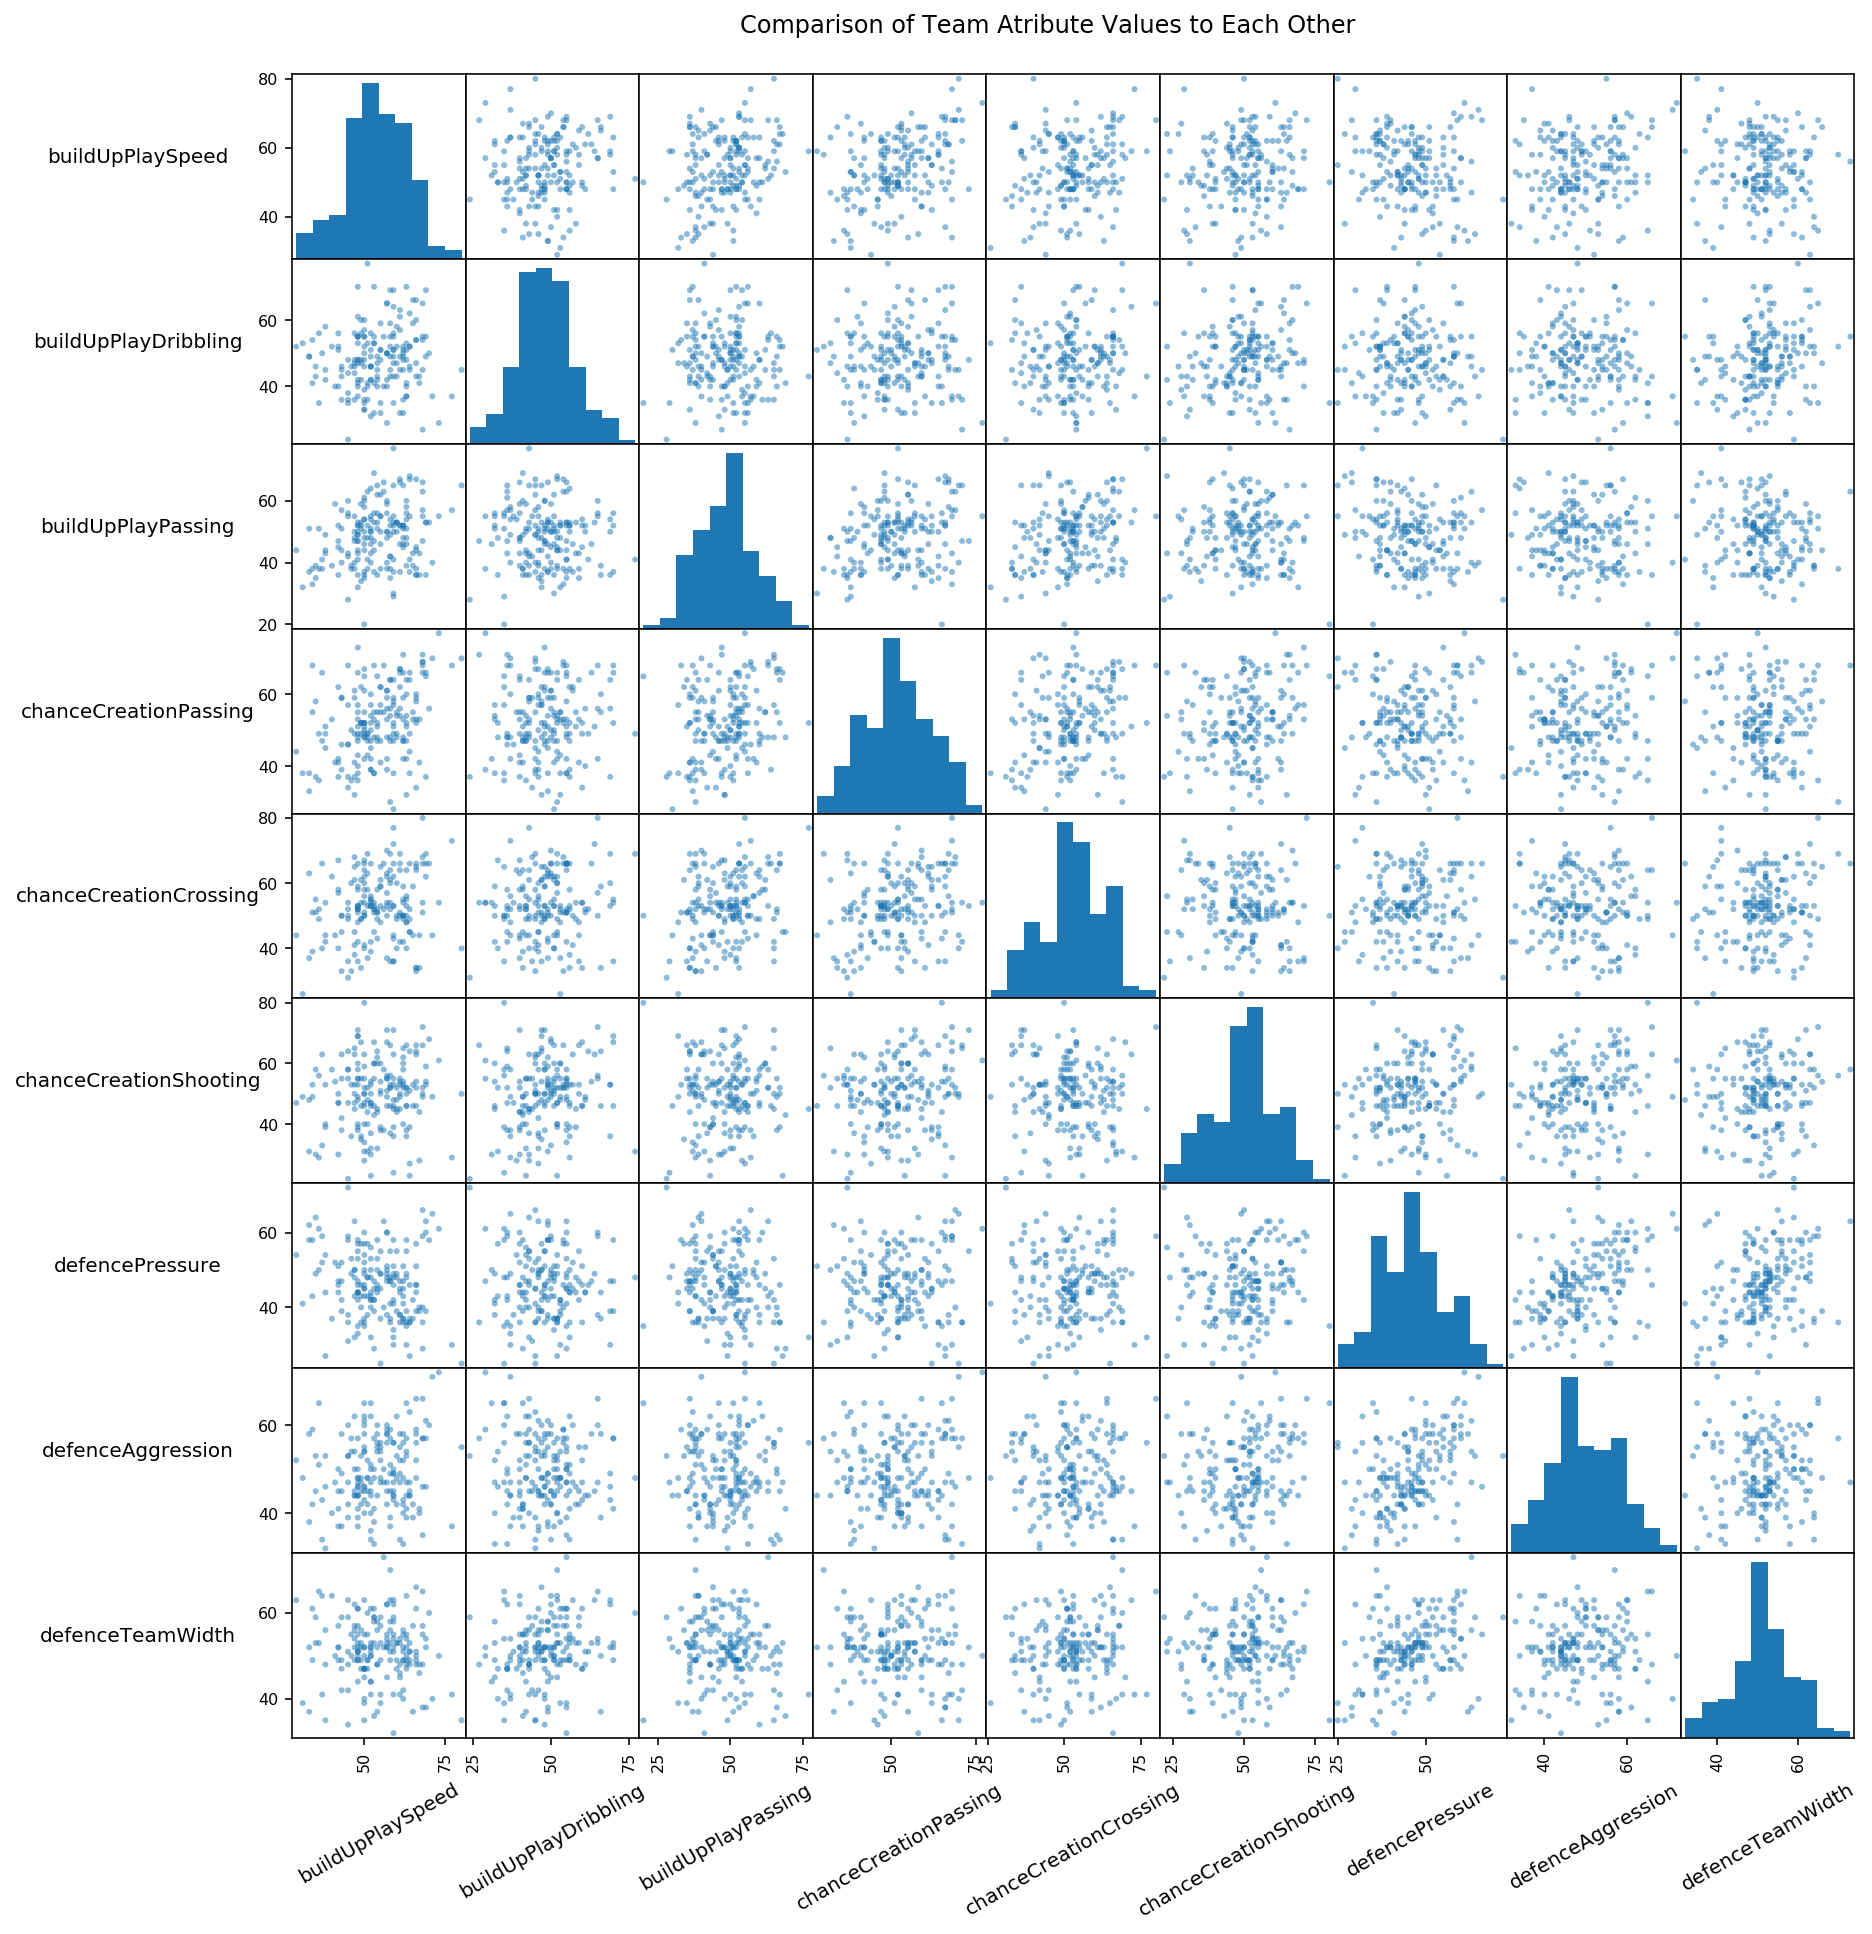

In [45]:
ax = pd.plotting.scatter_matrix(tap[['buildUpPlaySpeed', 'buildUpPlayDribbling', 'buildUpPlayPassing', \
                    'chanceCreationPassing', 'chanceCreationCrossing', 'chanceCreationShooting', \
                    'defencePressure', 'defenceAggression', 'defenceTeamWidth']],\
                  figsize=(14, 14), alpha=.5);
plt.suptitle('Comparison of Team Atribute Values to Each Other')
plt.subplots_adjust(top=0.95)
for x in ax:
    for y in x:
        y.xaxis.label.set_rotation(30)
        y.xaxis.label.set_fontsize(10)
        y.yaxis.label.set_rotation(0)
        y.yaxis.label.set_fontsize(10)
        y.yaxis.labelpad = 60


All atributes are fairly normally distributed which is interesting, although certain ones such as chanceCreationShooting have marked peaks around the mean.

Just glancing at it it appears the most strongly correlated are defencePressure and defenceAgression, and this is confirmed by looking at the pearson scores below. Other than this there are not many other significant correlations.

In [46]:
tap[['buildUpPlaySpeed', 'buildUpPlayDribbling', 'buildUpPlayPassing', \
                     'chanceCreationPassing', 'chanceCreationCrossing', 'chanceCreationShooting', \
                     'defencePressure', 'defenceAggression', 'defenceTeamWidth']].corr()

,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
buildUpPlaySpeed,1.000000,0.087381,0.271147,0.341316,0.193050,0.113977,-0.194584,0.161723,-0.074938
buildUpPlayDribbling,0.087381,1.000000,-0.040996,0.037785,0.113252,0.154651,-0.067958,-0.082998,0.199130
buildUpPlayPassing,0.271147,-0.040996,1.000000,0.240317,0.279081,-0.023116,-0.221814,-0.070782,-0.102902
chanceCreationPassing,0.341316,0.037785,0.240317,1.000000,0.263966,0.188520,0.029739,0.084501,-0.056079
chanceCreationCrossing,0.193050,0.113252,0.279081,0.263966,1.000000,-0.071313,0.005091,0.002636,0.118935
chanceCreationShooting,0.113977,0.154651,-0.023116,0.188520,-0.071313,1.000000,0.089450,0.189511,0.072678
defencePressure,-0.194584,-0.067958,-0.221814,0.029739,0.005091,0.089450,1.000000,0.414663,0.340805
defenceAggression,0.161723,-0.082998,-0.070782,0.084501,0.002636,0.189511,0.414663,1.000000,0.046237
defenceTeamWidth,-0.074938,0.199130,-0.102902,-0.056079,0.118935,0.072678,0.340805,0.046237,1.000000


In order to compare the class attributes relations to one another we need to prepare those columns.

We will first prepare a list of the class columns that need cleaning,

In [47]:
cols = ['buildUpPlaySpeedClass', 'buildUpPlayDribblingClass', 'buildUpPlayPassingClass', \
        'buildUpPlayPositioningClass', 'chanceCreationPassingClass', 'chanceCreationCrossingClass', \
        'chanceCreationShootingClass', 'chanceCreationPositioningClass', 'defencePressureClass', \
        'defenceAggressionClass', 'defenceTeamWidthClass', 'defenceDefenderLineClass']
[tap.columns.get_loc(c) for c in tap.columns if c in cols]

[2, 4, 6, 7, 9, 11, 13, 14, 16, 18, 20, 21]

And will now merge the column name ahead of the element and remove spaces.

In [48]:
for col in cols:
    tap[col].replace(' ', '_', regex=True, inplace=True)
    tap[col] = col + '_' + tap[col]
tap.head()

,team_api_id,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,...,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass,team_long_name,h_ppg,a_ppg,o_ppg
0,1601,47,buildUpPlaySpeedClass_Balanced,48.0,buildUpPlayDribblingClass_Normal,38,buildUpPlayPassingClass_Mixed,buildUpPlayPositioningClass_Organised,61,chanceCreationPassingClass_Normal,...,defencePressureClass_Medium,44,defenceAggressionClass_Press,49,defenceTeamWidthClass_Normal,defenceDefenderLineClass_Cover,Ruch Chorzów,1.333333,1.266667,1.300000
1,1773,52,buildUpPlaySpeedClass_Balanced,51.0,buildUpPlayDribblingClass_Normal,50,buildUpPlayPassingClass_Mixed,buildUpPlayPositioningClass_Organised,50,chanceCreationPassingClass_Normal,...,defencePressureClass_Medium,44,defenceAggressionClass_Press,50,defenceTeamWidthClass_Normal,defenceDefenderLineClass_Cover,Oud-Heverlee Leuven,1.333333,0.600000,0.966667
2,1957,66,buildUpPlaySpeedClass_Balanced,54.0,buildUpPlayDribblingClass_Normal,38,buildUpPlayPassingClass_Mixed,buildUpPlayPositioningClass_Organised,53,chanceCreationPassingClass_Normal,...,defencePressureClass_Medium,56,defenceAggressionClass_Press,49,defenceTeamWidthClass_Normal,defenceDefenderLineClass_Cover,Jagiellonia Białystok,1.400000,0.933333,1.166667
3,2182,57,buildUpPlaySpeedClass_Balanced,50.0,buildUpPlayDribblingClass_Normal,40,buildUpPlayPassingClass_Mixed,buildUpPlayPositioningClass_Free_Form,59,chanceCreationPassingClass_Normal,...,defencePressureClass_Medium,58,defenceAggressionClass_Press,45,defenceTeamWidthClass_Normal,defenceDefenderLineClass_Cover,Lech Poznań,1.400000,1.466667,1.433333
4,2186,37,buildUpPlaySpeedClass_Balanced,50.0,buildUpPlayDribblingClass_Normal,38,buildUpPlayPassingClass_Mixed,buildUpPlayPositioningClass_Organised,66,chanceCreationPassingClass_Normal,...,defencePressureClass_Medium,34,defenceAggressionClass_Press,64,defenceTeamWidthClass_Normal,defenceDefenderLineClass_Cover,Cracovia,1.666667,1.333333,1.500000


And then merge these class columns.

In [49]:
tap['class_composite'] = tap.iloc[ :, np.r_[2, 4, 6, 7, 9, 11, 13, 14, 16, 18, 20, 21]]\
                    .apply(lambda x: ' '.join(x),axis=1)

We then need to import a count vectorizer function inorder to compare the occurence of words together, making a co-occurence matrix, much of this method was found in this [Stack Overflow discussion](https://stackoverflow.com/questions/35562789/word-word-co-occurrence-matrix/37822989#37822989).

In [50]:
from sklearn.feature_extraction.text import CountVectorizer

count_model = CountVectorizer(ngram_range=(1,1))
X = count_model.fit_transform(tap.class_composite)
Xc = (X.T * X) #Sparse csr format
Xc.setdiag(0) #Remove one to one values
count_vector = pd.DataFrame(Xc.todense())
count_vector.index = count_vector.columns = count_model.get_feature_names()

In [51]:
count_vector.head()

,buildupplaydribblingclass_little,buildupplaydribblingclass_lots,buildupplaydribblingclass_normal,buildupplaypassingclass_long,buildupplaypassingclass_mixed,buildupplaypassingclass_short,buildupplaypositioningclass_free_form,buildupplaypositioningclass_organised,buildupplayspeedclass_balanced,buildupplayspeedclass_fast,...,defenceaggressionclass_double,defenceaggressionclass_press,defencedefenderlineclass_cover,defencedefenderlineclass_offside_trap,defencepressureclass_deep,defencepressureclass_high,defencepressureclass_medium,defenceteamwidthclass_narrow,defenceteamwidthclass_normal,defenceteamwidthclass_wide
buildupplaydribblingclass_little,0,0,0,0,13,1,1,13,12,2,...,1,12,14,0,1,1,12,0,14,0
buildupplaydribblingclass_lots,0,0,0,0,7,0,0,7,6,1,...,0,7,6,1,1,0,6,0,7,0
buildupplaydribblingclass_normal,0,0,0,6,151,6,9,154,147,12,...,1,160,161,2,12,0,151,1,160,2
buildupplaypassingclass_long,0,0,6,0,0,0,0,6,6,0,...,0,6,6,0,3,0,3,0,6,0
buildupplaypassingclass_mixed,13,7,151,0,0,0,8,163,153,15,...,2,166,168,3,11,0,160,1,168,2


After finding this co-ocurrence matrix we can plot it as a heatmap. This graph shows the frequency of certain play classes appearing with each other.

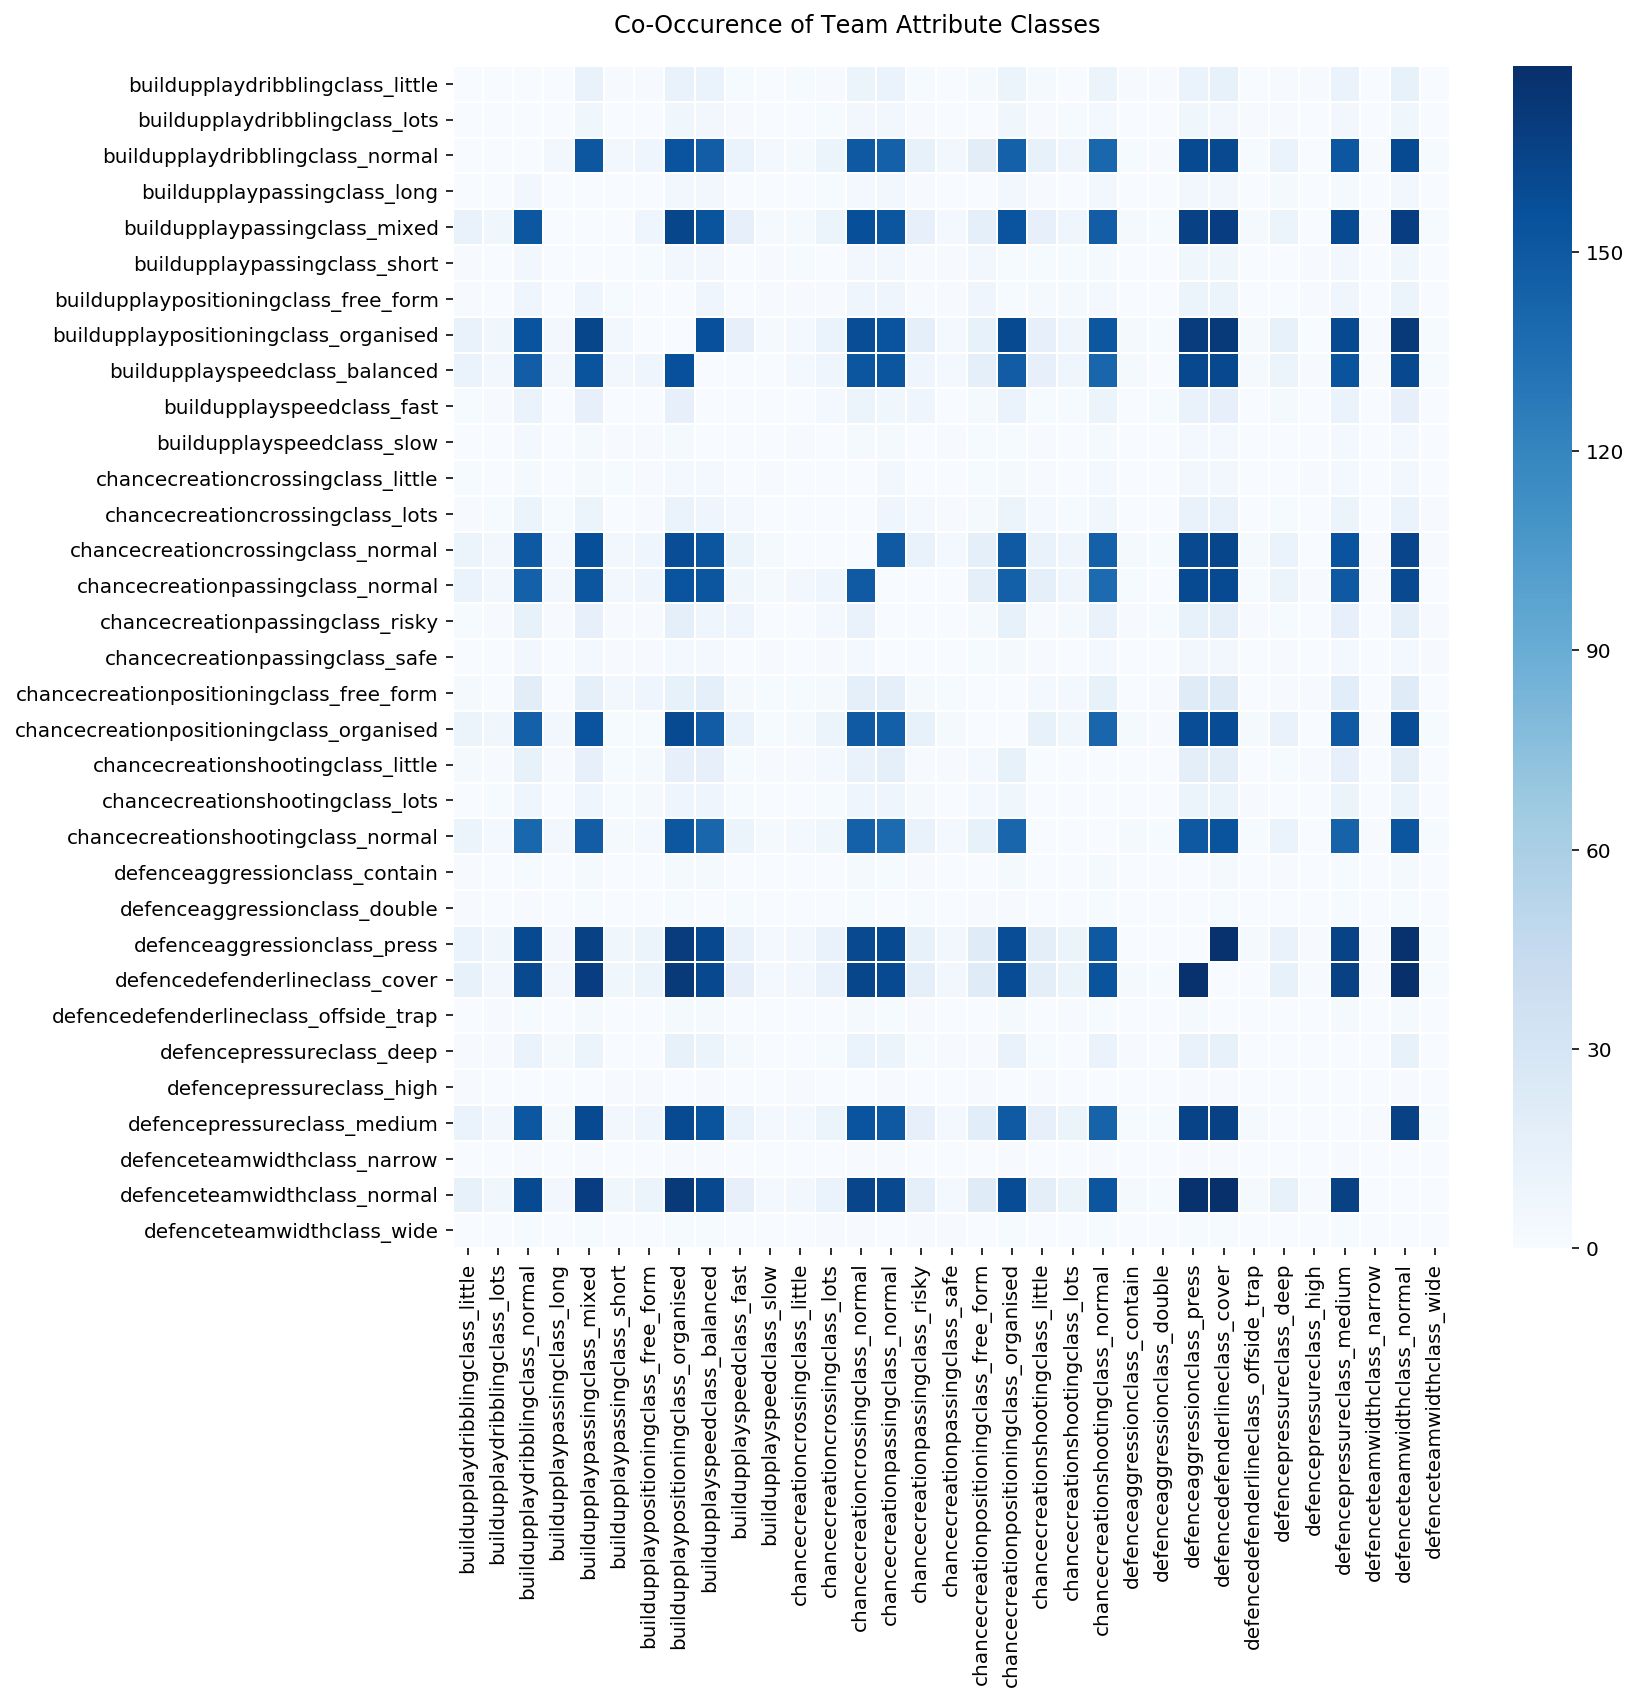

In [52]:
f, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(count_vector, cmap='Blues', annot = False, fmt='.0f', cbar=True, linewidths=.5)
f.suptitle('Co-Occurence of Team Attribute Classes')
f.tight_layout()
f.subplots_adjust(top=0.95)

This shows that there are a few dominant pairings (and 12 dominant rows) of these classes such as organised build up passing play and press defence agression. Looking at the overall counts of these classes the clear 12 dominant classes can be seen.

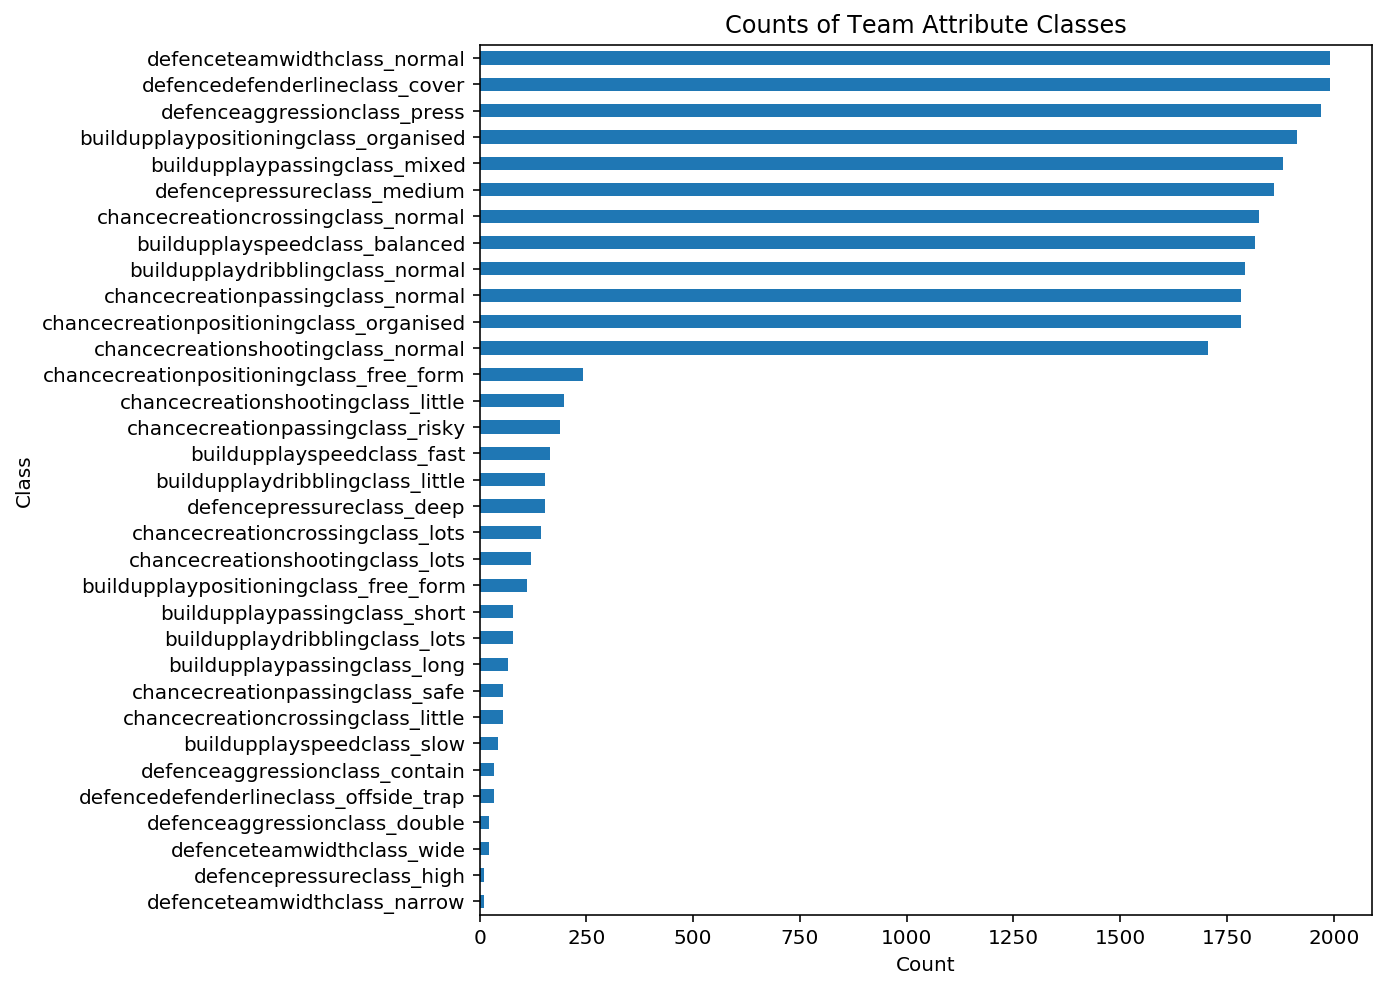

In [53]:
ax = count_vector.sum().sort_values().plot(kind='barh', figsize=(8,8), title='Counts of Team Attribute Classes')
ax.set_xlabel('Count')
ax.set_ylabel('Class');

Another aspect that could be explored is if leagues/countries exhibit common playstyles.

From the angle of team attributes the data set is limiting in that it only has one year. It would be intersting to be able to see if a teams change in playstyle would lead to success in the next year, and if there are overall trends in playstyle from year to year.

Another limiting factor is that it lacks inter league tournaments such as the Champions League which could be interesting to explore in relation to either countries performance or the general playstyle (from attributes) of that country.

### References

European Soccer Database - Hugo Mathien - [Kaggle](https://www.kaggle.com/hugomathien/soccer)

Word co-occurence method - titipata - [Stack Overflow](https://stackoverflow.com/a/37822989)